# Code Part

## Download Dataset


In [ ]:
!pip -q install wfdb==3.4.0 
!wget -q https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip
!unzip -qo /content/mit-bih-arrhythmia-database-1.0.0.zip 

     |████████████████████████████████| 137 kB 8.5 MB/s 


## Change the ECG Signal

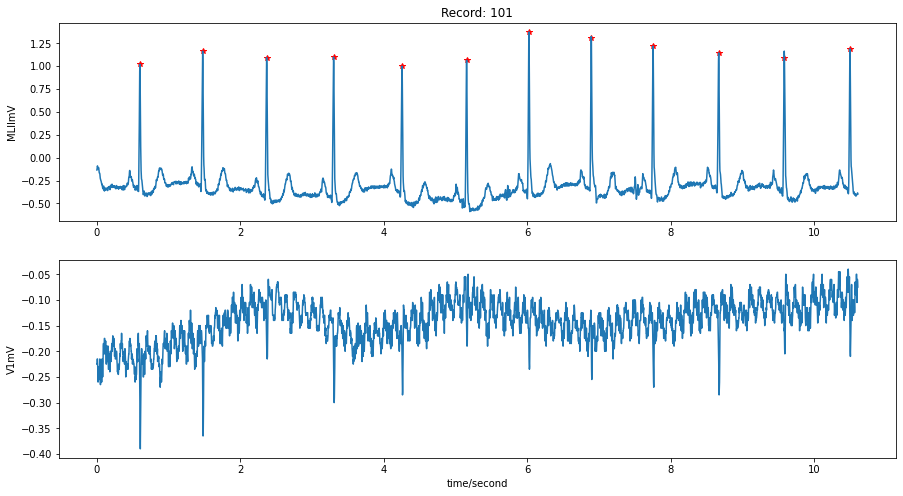

In [57]:
#@title Choose ECG Signal { form-width: "20%", display-mode: "both" }
signal_number = 1 #@param {type:"slider", min:0, max:9, step:1}
import wfdb
import numpy as np

filename = f'/content/mit-bih-arrhythmia-database-1.0.0/{str(100 + signal_number)}'
record = wfdb.rdrecord(filename, sampfrom=180, sampto=4000,)    
annotation = wfdb.rdann(filename, 'atr', sampfrom=180, sampto=4000,shift_samps=True)

wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

## QRS Detection
(3marks)

In [58]:
import pandas as pd
import numpy as np
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    '''
    
    '''
    The first filter that we will apply to the signal is low pass filter and then we will apply 
    high pass filter. This band pass filter will reduce the muscle noise, T-wave interference. The
    difference equation for the low pass filter and the high pass filter are y(nT) = 2y(nT - T) - y(nT - 2 T) + x(nT)
    - 2x(nT- 6T)+x(nT- 12T) and y(nT) = [y(nT - T) + x(nT)/32 + x(nT-16T) -x(nT-17T) +x(nT - 32 T)/32] respectively. So by using
    this difference equation we will update the values in the signal. 

    '''
    Bp=signal.copy()
    for i in range(12,len(Bp)):
        Bp.iloc[i,1]=2*Bp.iloc[i-1,1]-Bp.iloc[i-2,1]+signal.iloc[i,1]-2*signal.iloc[i-6,1]+signal.iloc[i-12,1]
    for j in range(32,len(Bp)):
        Bp.iloc[j,1]=Bp.iloc[j-1,1]-signal.iloc[j,1]/32+signal.iloc[j-16,1]-signal.iloc[j-17,1] +signal.iloc[j-32,1]/32
    return Bp
    

  
  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    
    '''
    '''
    Now, we will apply the derivative filter to the signal the Difference equation of the derivation filter is as follows
    according to the Pan-Tompkins Algorithm: y(nT)=(2x(nT)+x(nT-T)-x(nT-3T)-2x(nT-4T))/8
    '''
    Der = signal.copy()
    for i in range(4,len(Der)):
        Der.iloc[i, 1] = (2*signal.iloc[i,1] + signal.iloc[i-1,1] - signal.iloc[i-3,1] - 2*signal.iloc[i-4,1])/8
    return Der
  
    

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    '''
    '''
    Now, the squaring filter is applied and the difference equation is 
    y(nT)=(x(nT))^2.
    '''
    sqr = signal.copy()
    for i in range(len(sqr)):
      sqr.iloc[i,1] = signal.iloc[i,1]**2
    return sqr
 

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    '''
    '''
    The moving window Integration has the following difference equation:
    y(nT)=(1/N)*(x(nT-(N-1)T)+x(nT-(N-2)T)+...+x(nT))
    '''
    s=30
    mw = signal.copy()
    for i in range(s,len(mw)-s):
      temp=0
      for j in range(i-s,i):
        temp += signal.iloc[j,1]
      mw.iloc[i,1] = temp/(s)		
    return mw

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: processed signal

    Methodology/Explaination (min 2-3 lines):
    [TODO] 
    '''
    bp=self.band_pass_filter(ecg)
    der=self.derivative(bp)
    sqr=self.squaring(der)
    output_signal=self.moving_window_integration(sqr)
    return output_signal

QRS_detector = Pan_Tompkins_QRS()
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
output_signal = QRS_detector.solve(ecg)

## Plotting the Signals
consider using matlplotlib(or other plotting libraries) to create images for report. Please write code below \\
(1mark)

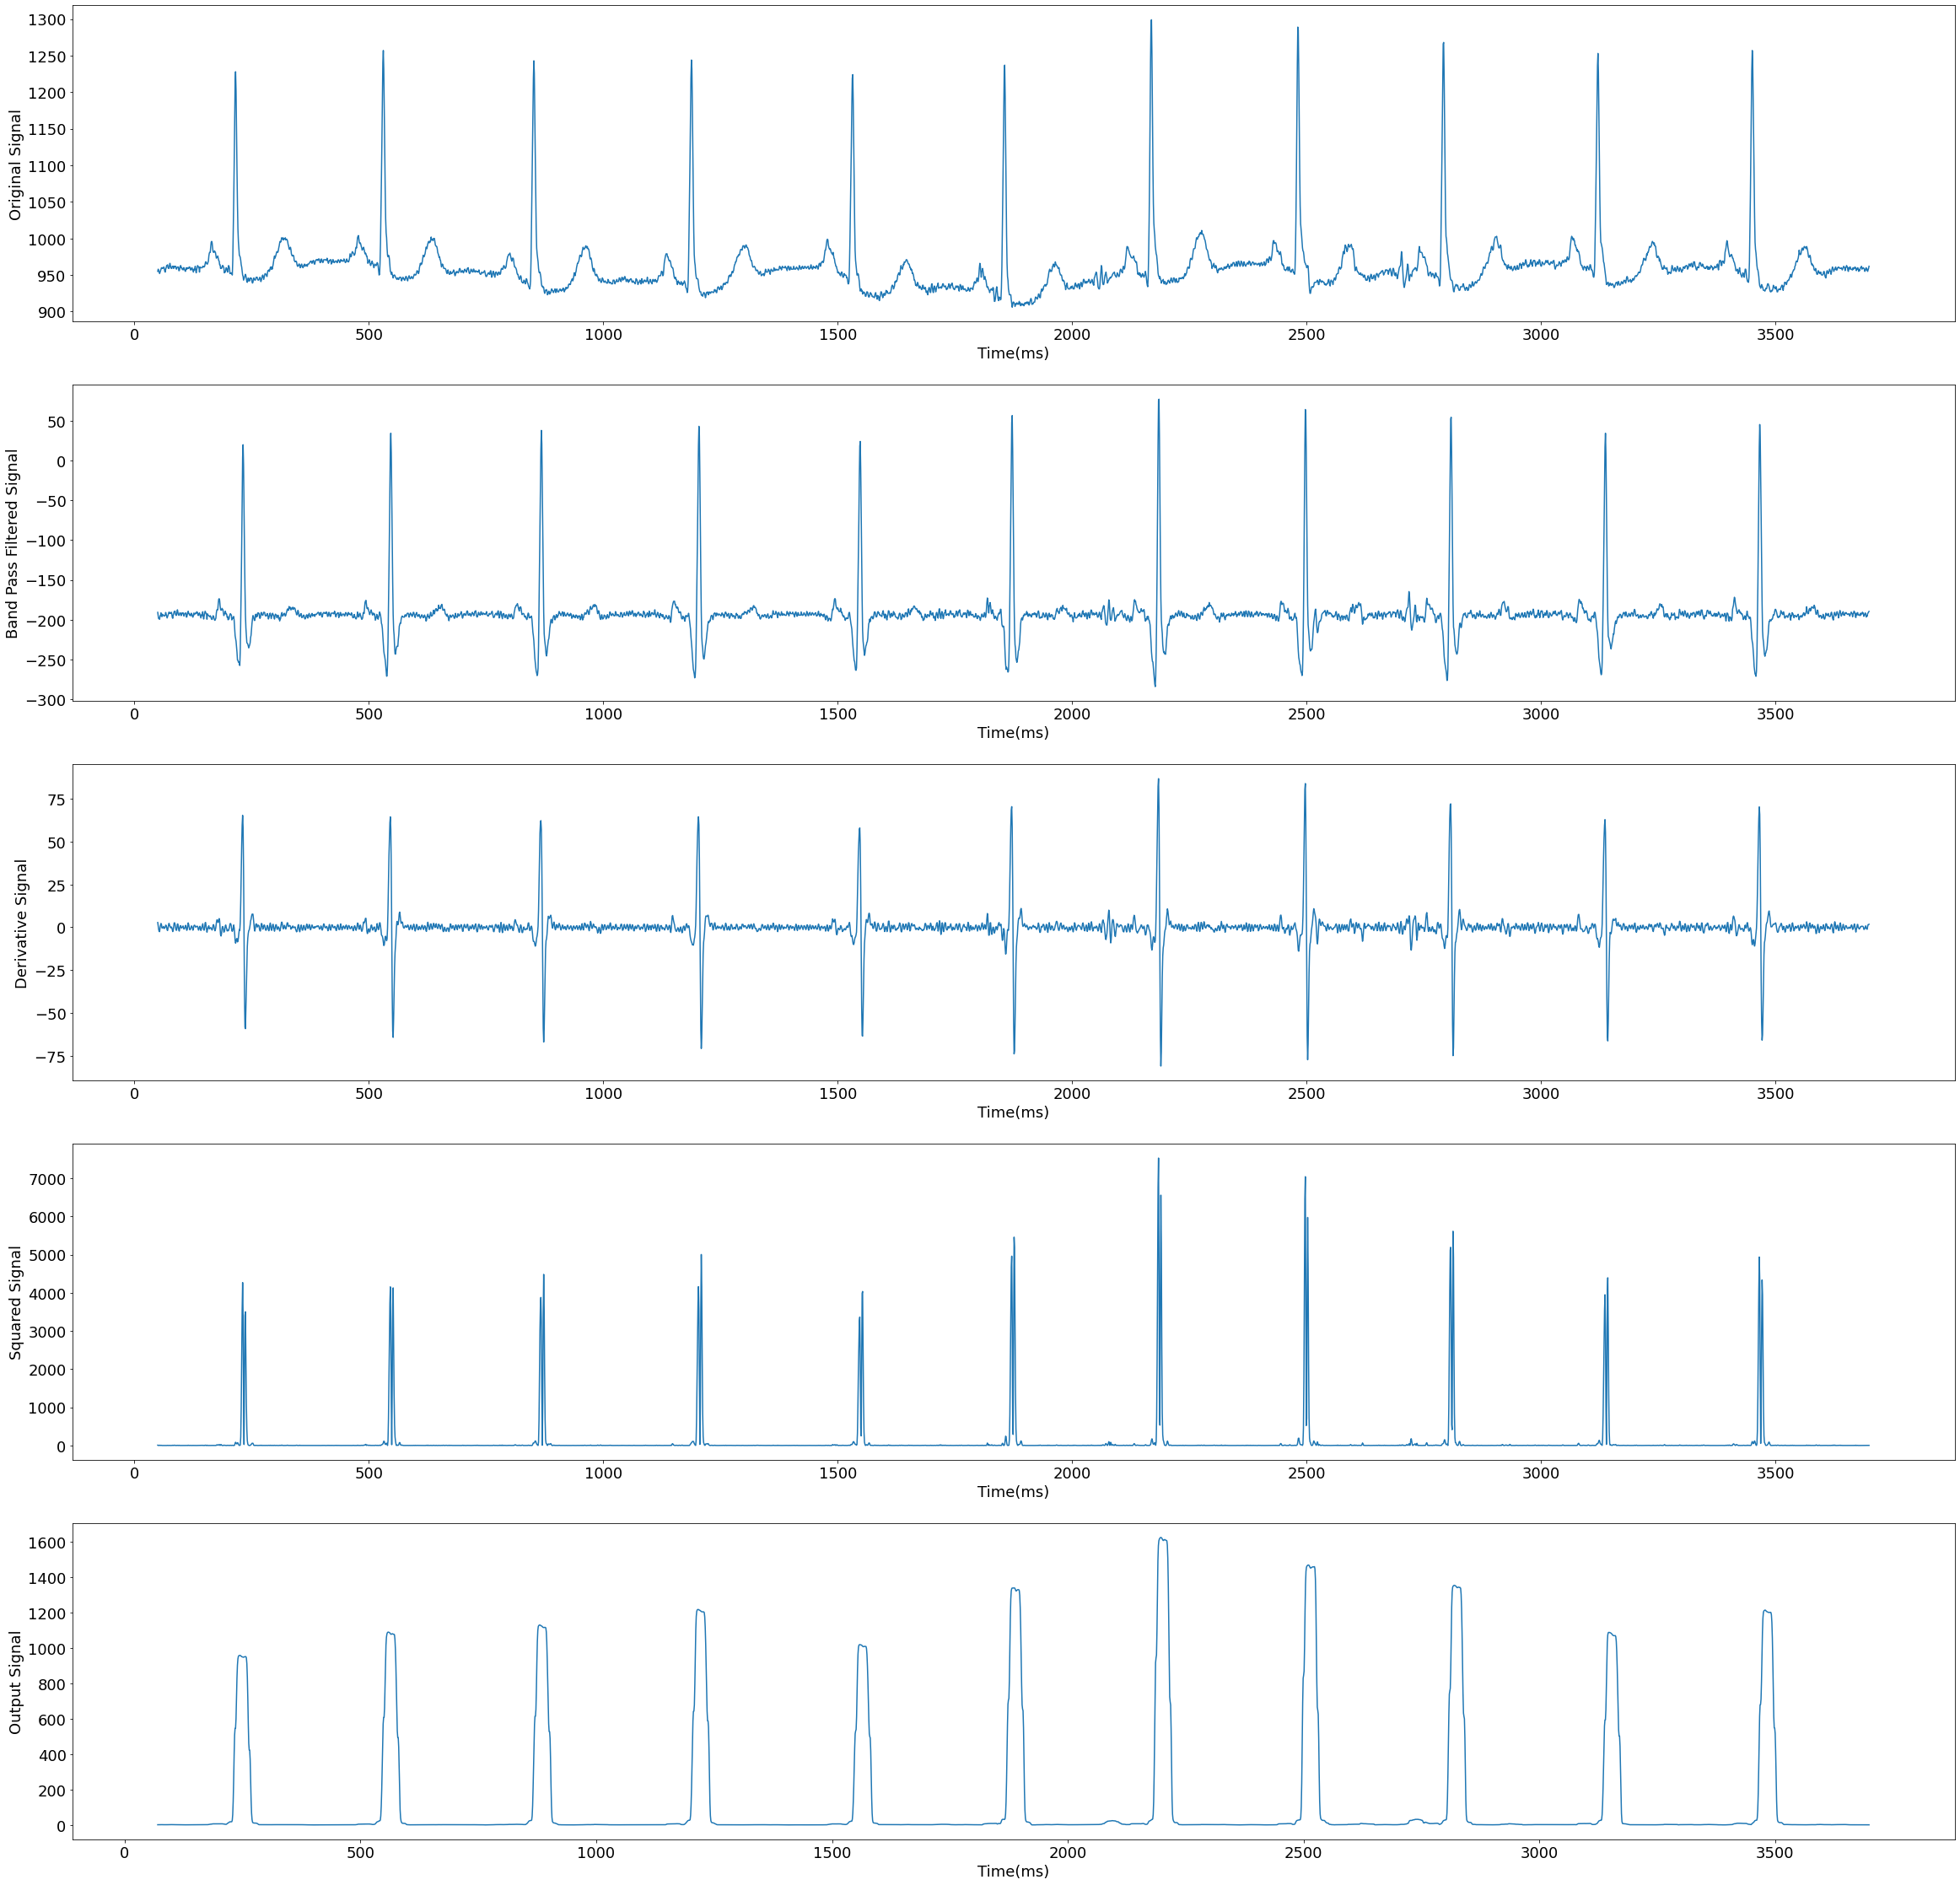

In [59]:
import matplotlib.pyplot as plt
QRS_detector = Pan_Tompkins_QRS()
ecg = pd.DataFrame(np.array([list(range(len(record.adc()))),record.adc()[:,0]]).T,columns=['TimeStamp','ecg'])
bp=QRS_detector.band_pass_filter(ecg.copy())
der=QRS_detector.derivative(bp.copy())
sqr=QRS_detector.squaring(der.copy())

plt.figure(figsize=(40,40))
plt.subplot(5,1,1)
plt.plot(ecg['TimeStamp'][50:3700],ecg['ecg'][50:3700])
plt.xlabel('Time(ms)',fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Original Signal',fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(5,1,2)
plt.plot(bp['TimeStamp'][50:3700],bp['ecg'][50:3700])
plt.xlabel('Time(ms)',fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Band Pass Filtered Signal',fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(5,1,3)
plt.plot(der['TimeStamp'][50:3700],der['ecg'][50:3700])
plt.xlabel('Time(ms)',fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Derivative Signal',fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(5,1,4)
plt.plot(sqr['TimeStamp'][50:3700],sqr['ecg'][50:3700])
plt.xlabel('Time(ms)',fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Squared Signal',fontsize=18)
plt.yticks(fontsize=18)

plt.subplot(5,1,5)
plt.plot(output_signal['TimeStamp'][70:3700],output_signal['ecg'][70:3700])
plt.xlabel('Time(ms)',fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Output Signal',fontsize=18)
plt.yticks(fontsize=18)

plt.show()

## Calculating Heart Rate
In this section you need to write code to calculate heart rate of the given ecg signal using the help of QRS detected. \\
(1mark)

In [62]:
def heart_rate(output_signal):
  
  spki,npki,t1,t2=0,0,0,0
  threshold1=400
  threshold2=threshold1/2
  time=output_signal['TimeStamp']
  output_signal=output_signal['ecg']
  peak_Time=[]
  rate=[]
  i=1
  
  while (i<=len(output_signal)-2):
    if ((output_signal[i]>output_signal[i+1] and output_signal[i]>threshold1 ) and ( output_signal[i]>output_signal[i-1]and time[i]-t1>200)):
      if output_signal[i]<threshold1:
        npki=0.125*output_signal[i]+0.875*npki
        threshold1=npki+0.25*(spki-npki)
        threshold2=threshold1/2

      else:
        spki=0.125*output_signal[i]+0.875*spki
        t2=i
        t1=time[i]
        peak_Time.append(time[i])
        threshold1=npki+0.25*(spki-npki)
        threshold2=threshold1/2
        
    if time[i]-t1>600:
      for k in range(t1,i):
        if (output_signal[k]>output_signal[k+1] and output_signal[k]>threshold2 and output_signal[k]>output_signal[k-1]):
          spki=0.25*output_signal[k]+0.75*spki
          threshold1=npki+0.25*(spki-npki)
          peak_Time.append(time[k])
          threshold2=threshold1/2
    i+=1
  # Here i have assumed that the time stamps are in milli seconds.
  
  for i in range(1,len(peak_Time)-1):
    rate.append(60/((peak_Time[i+1]-peak_Time[i-1])*0.001))
  return sum(rate)/len(rate)

heart_rate_value=heart_rate(output_signal)
print('The heart rate as calculated using the PAN-Tompkins algorithm is '+ str(heart_rate_value))

The heart rate as calculated using the PAN-Tompkins algorithm is 92.78916621655688


# Report

## Your Understanding of the Algorithm
(2marks)

Pan-Tompkins algorithm helps us to determine the QRS complexes(combination of Q wave, R wave and S wave) from the ECG signal. The raw signal has many noises and disturbances in it and hence we need to filter it before determining the QRS complex. Pan-Tompkins algorithm helps us to accomplish the task. The algorithm has following steps:

1) Bandpass filter:
The bandpass filter consists of 2 filters namely low pass filter and high pass filter. We apply the band pass filter to the signal in order to reduce the influence of muscle noise, baseline wander, and T-wave interference. According to the Pan - Tompkins algorithm the characteristic equation of the low pass filter and the difference equation is as follows:

Low Pass Filter transfer function:

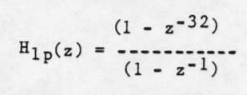

The difference equation is as follows:

y(nT) = 2y(nT - T) - y(nT - 2 T) + x(nT) - 2x(nT- 6T)+x(nT- 12T)

According to the Pan - Tompkins algorithm the characteristic equation of the high pass filter and the difference equation is as follows: 

High Pass Filter transfer function:

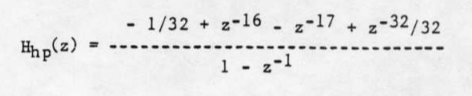

The difference equation is as follows:

 y(nT) = y(nT - T) + x(nT)/32 + x(nT-16T) -x(nT-17T) +x(nT - 32 T)/32


The band pass filter has a minimal processing delay. Hence, such an algorithm has real-time applications as well.

2) Derivative Filter:
Next we need to do the derivative of the signal as the there is a steep slope between the signal Q & R wave and R & S wave. Hence, the derivative of a signal can tell us regarding the change in slope. Thus, we can detect the QRS complex if any in the signal. The characteristic equation and the difference equation are as follows:

Derivative filter transfer function:

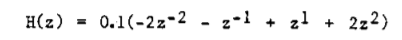

The difference equation:

y(nT)=(2x(nT)+x(nT-T)-x(nT-3T)-2x(nT-4T))/8

3) Squaring Function :
The main reason behind squaring the signal is reducing the dominance of the noise and disturbances in the signal. As the noise have lesser amplitude as compared to that important part of the signal and hence if square the signal it will decrease the impact of noise from the signal. 

The difference equation is as follows:

y(nT)=(x(nT))^2

4) Moving-Window Integration : 
In layman terms, we can say that when we apply the moving window integration, we did the summation of all the previous values in the given window. The benefit of doing this is: we can reduce the effect of local disturbances/noises as the values corresponding the noises are less. The moving window size is 30 here. 

The difference equation is as follows:

y(nT)=(1/N)*(x(nT-(N-1)T)+x(nT-(N-2)T)+...+x(nT))

5) Heart-Rate Detection :
After applying these filters on the raw signal we will be able to generate the QRS complexes in the signal and now we can use it to calculate the heart rate. Here, we will use the double thresholding technique in order to determine the peaks in the signal. The double thresholding techinque uses overall peak, running signal peak and noise peak in order to calculate the thresholds. The smaller threshold is half of the larger threshold. We check if the value of signal at some point is greater than larger threshold if yes we assign a peak to it. We also check that the time difference between the 2 peaks is greater than 200 ms or not. If we do not get any peak in 600 ms then we again search for the peak but by using the smaller threshold. On obtaining the peaks in the signal we calculate the average time period between 2 consecutive peaks. Then we obtain the heart rate per minutes by diving 60 by that average time beween 2 consecutive peaks(in seconds). 


## Results
(2marks)

You will have to show results for each signal 0-9 for the various filters over them. Do consider properly labeling your plots. Also report ***heart rate*** for each ecg signal.

Note: you can stick pictures, code is not required for this section
![picture](https://i.ibb.co/3C6r4qP/results-eg.png)

**Signal 0**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 103.50994771961345 beats per minute.

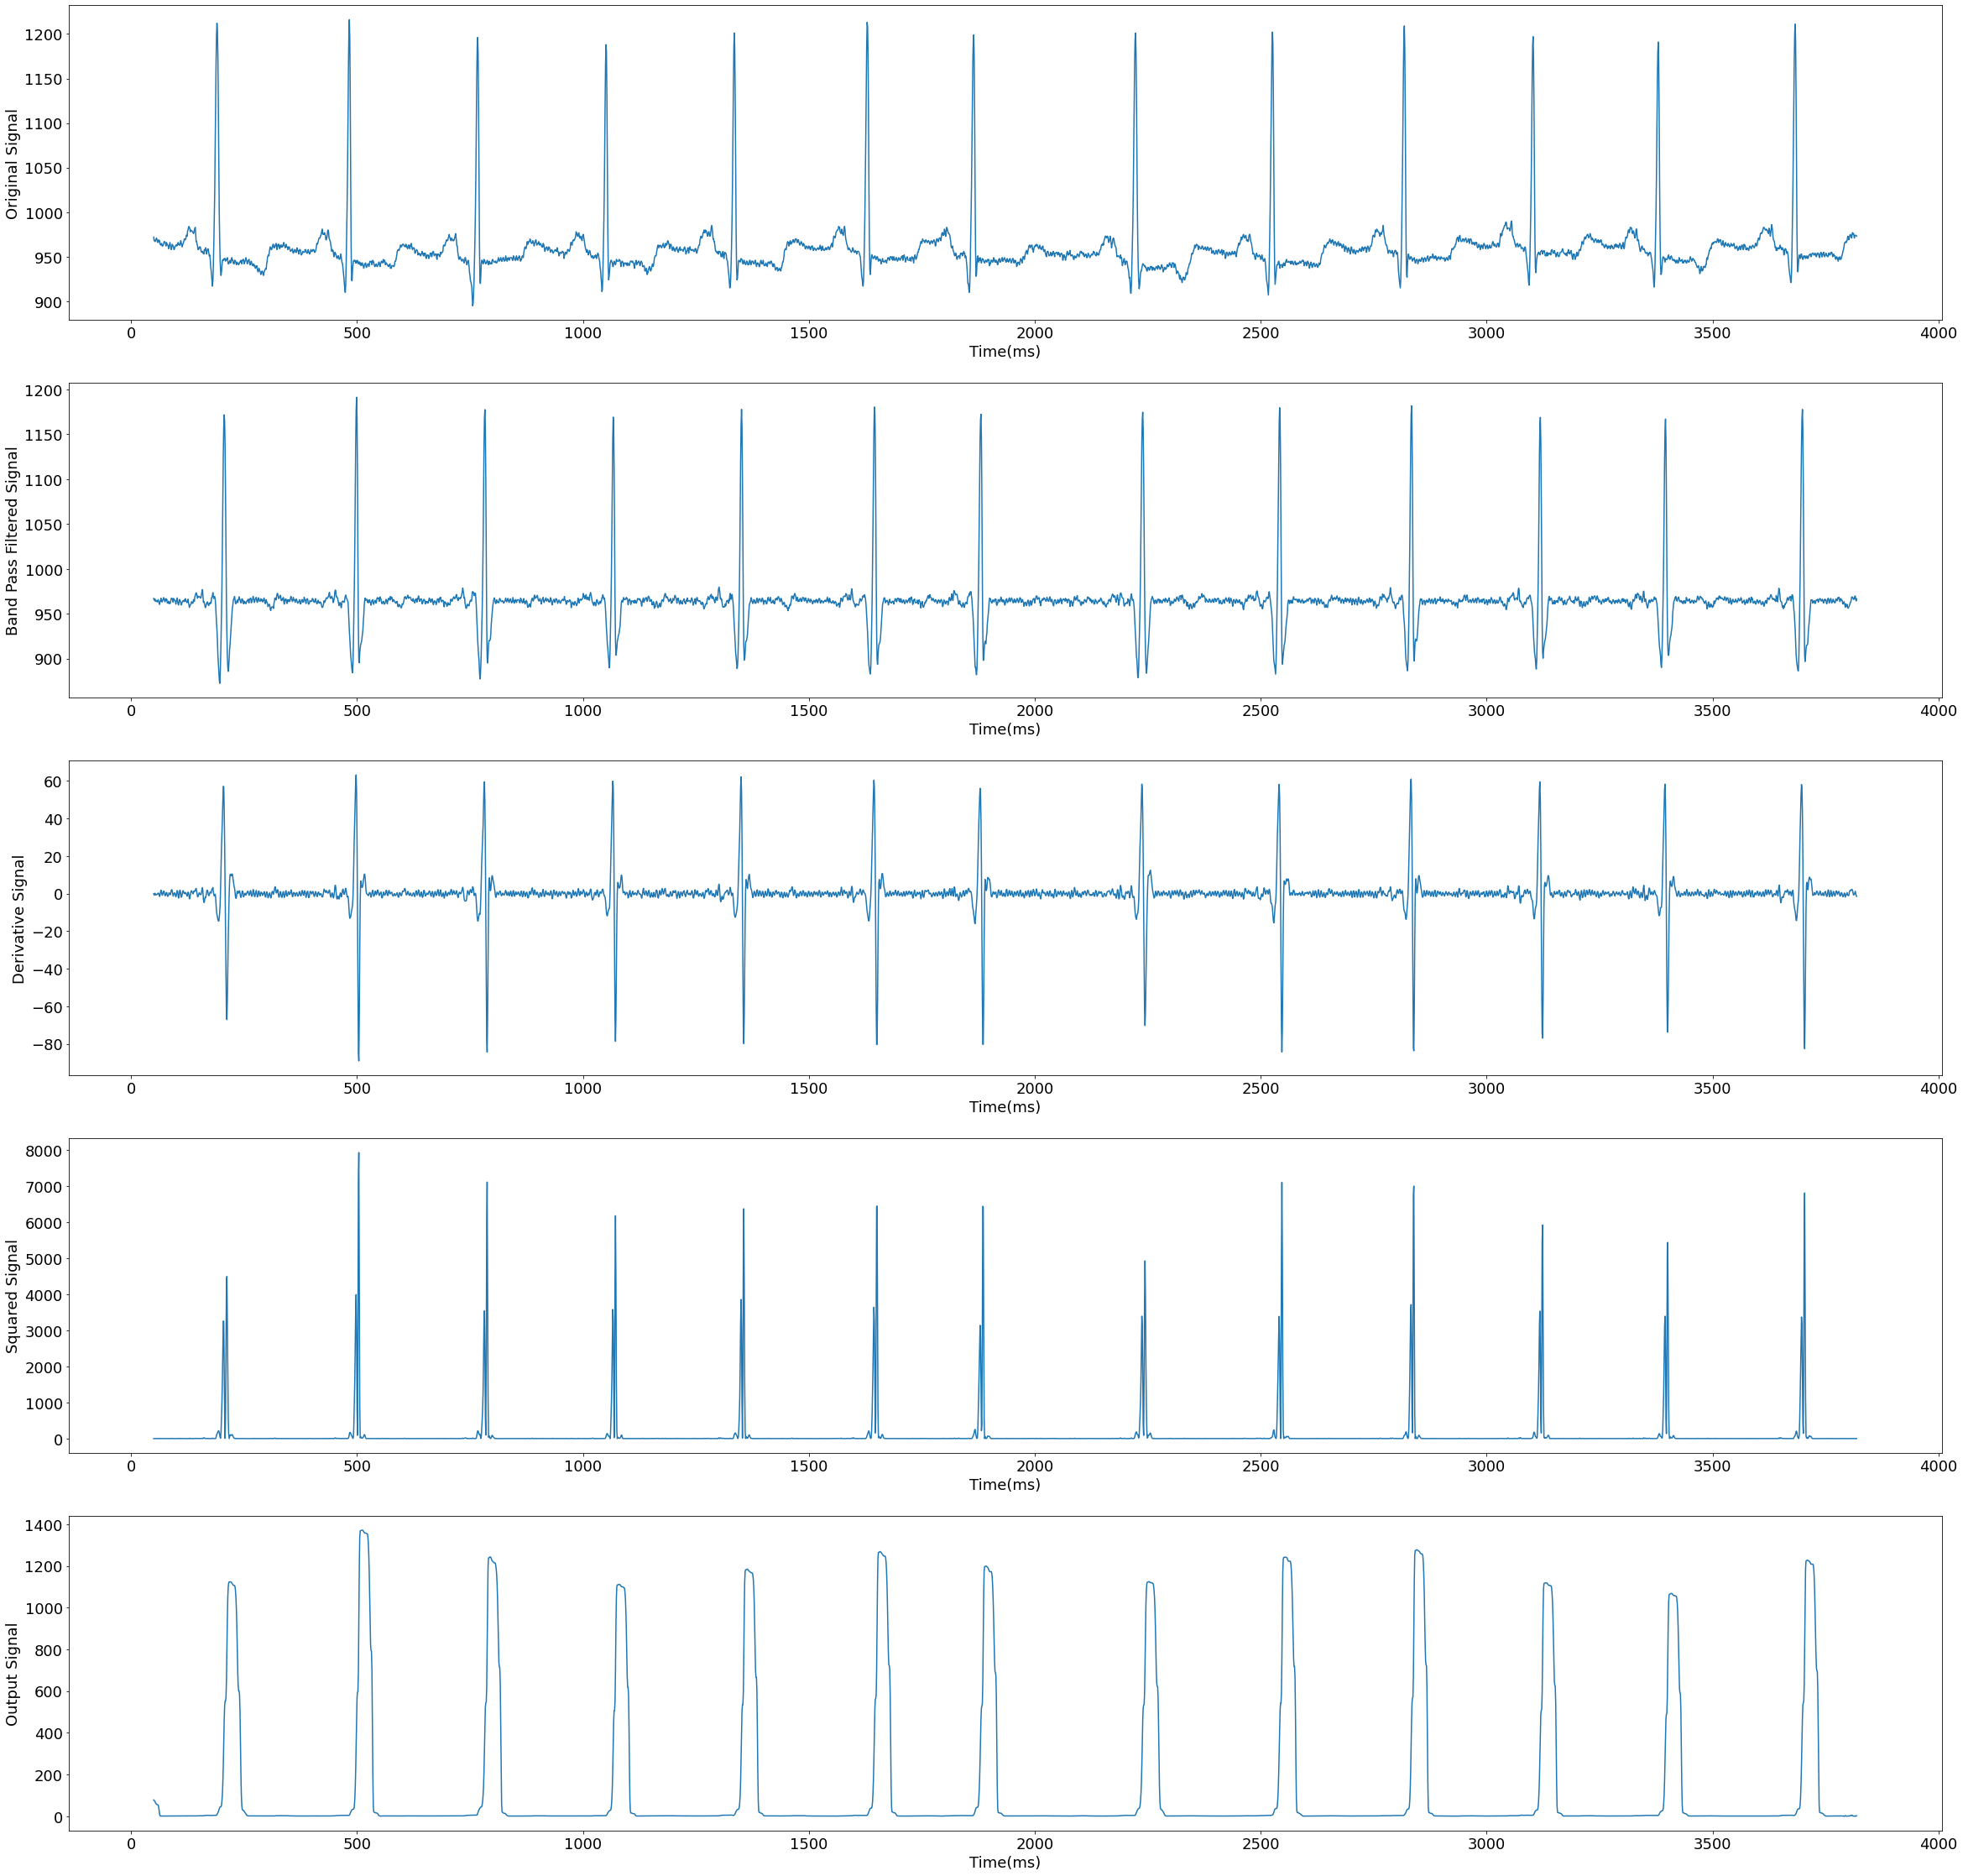

**Signal 1**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 92.78916621655688 beats per minute.

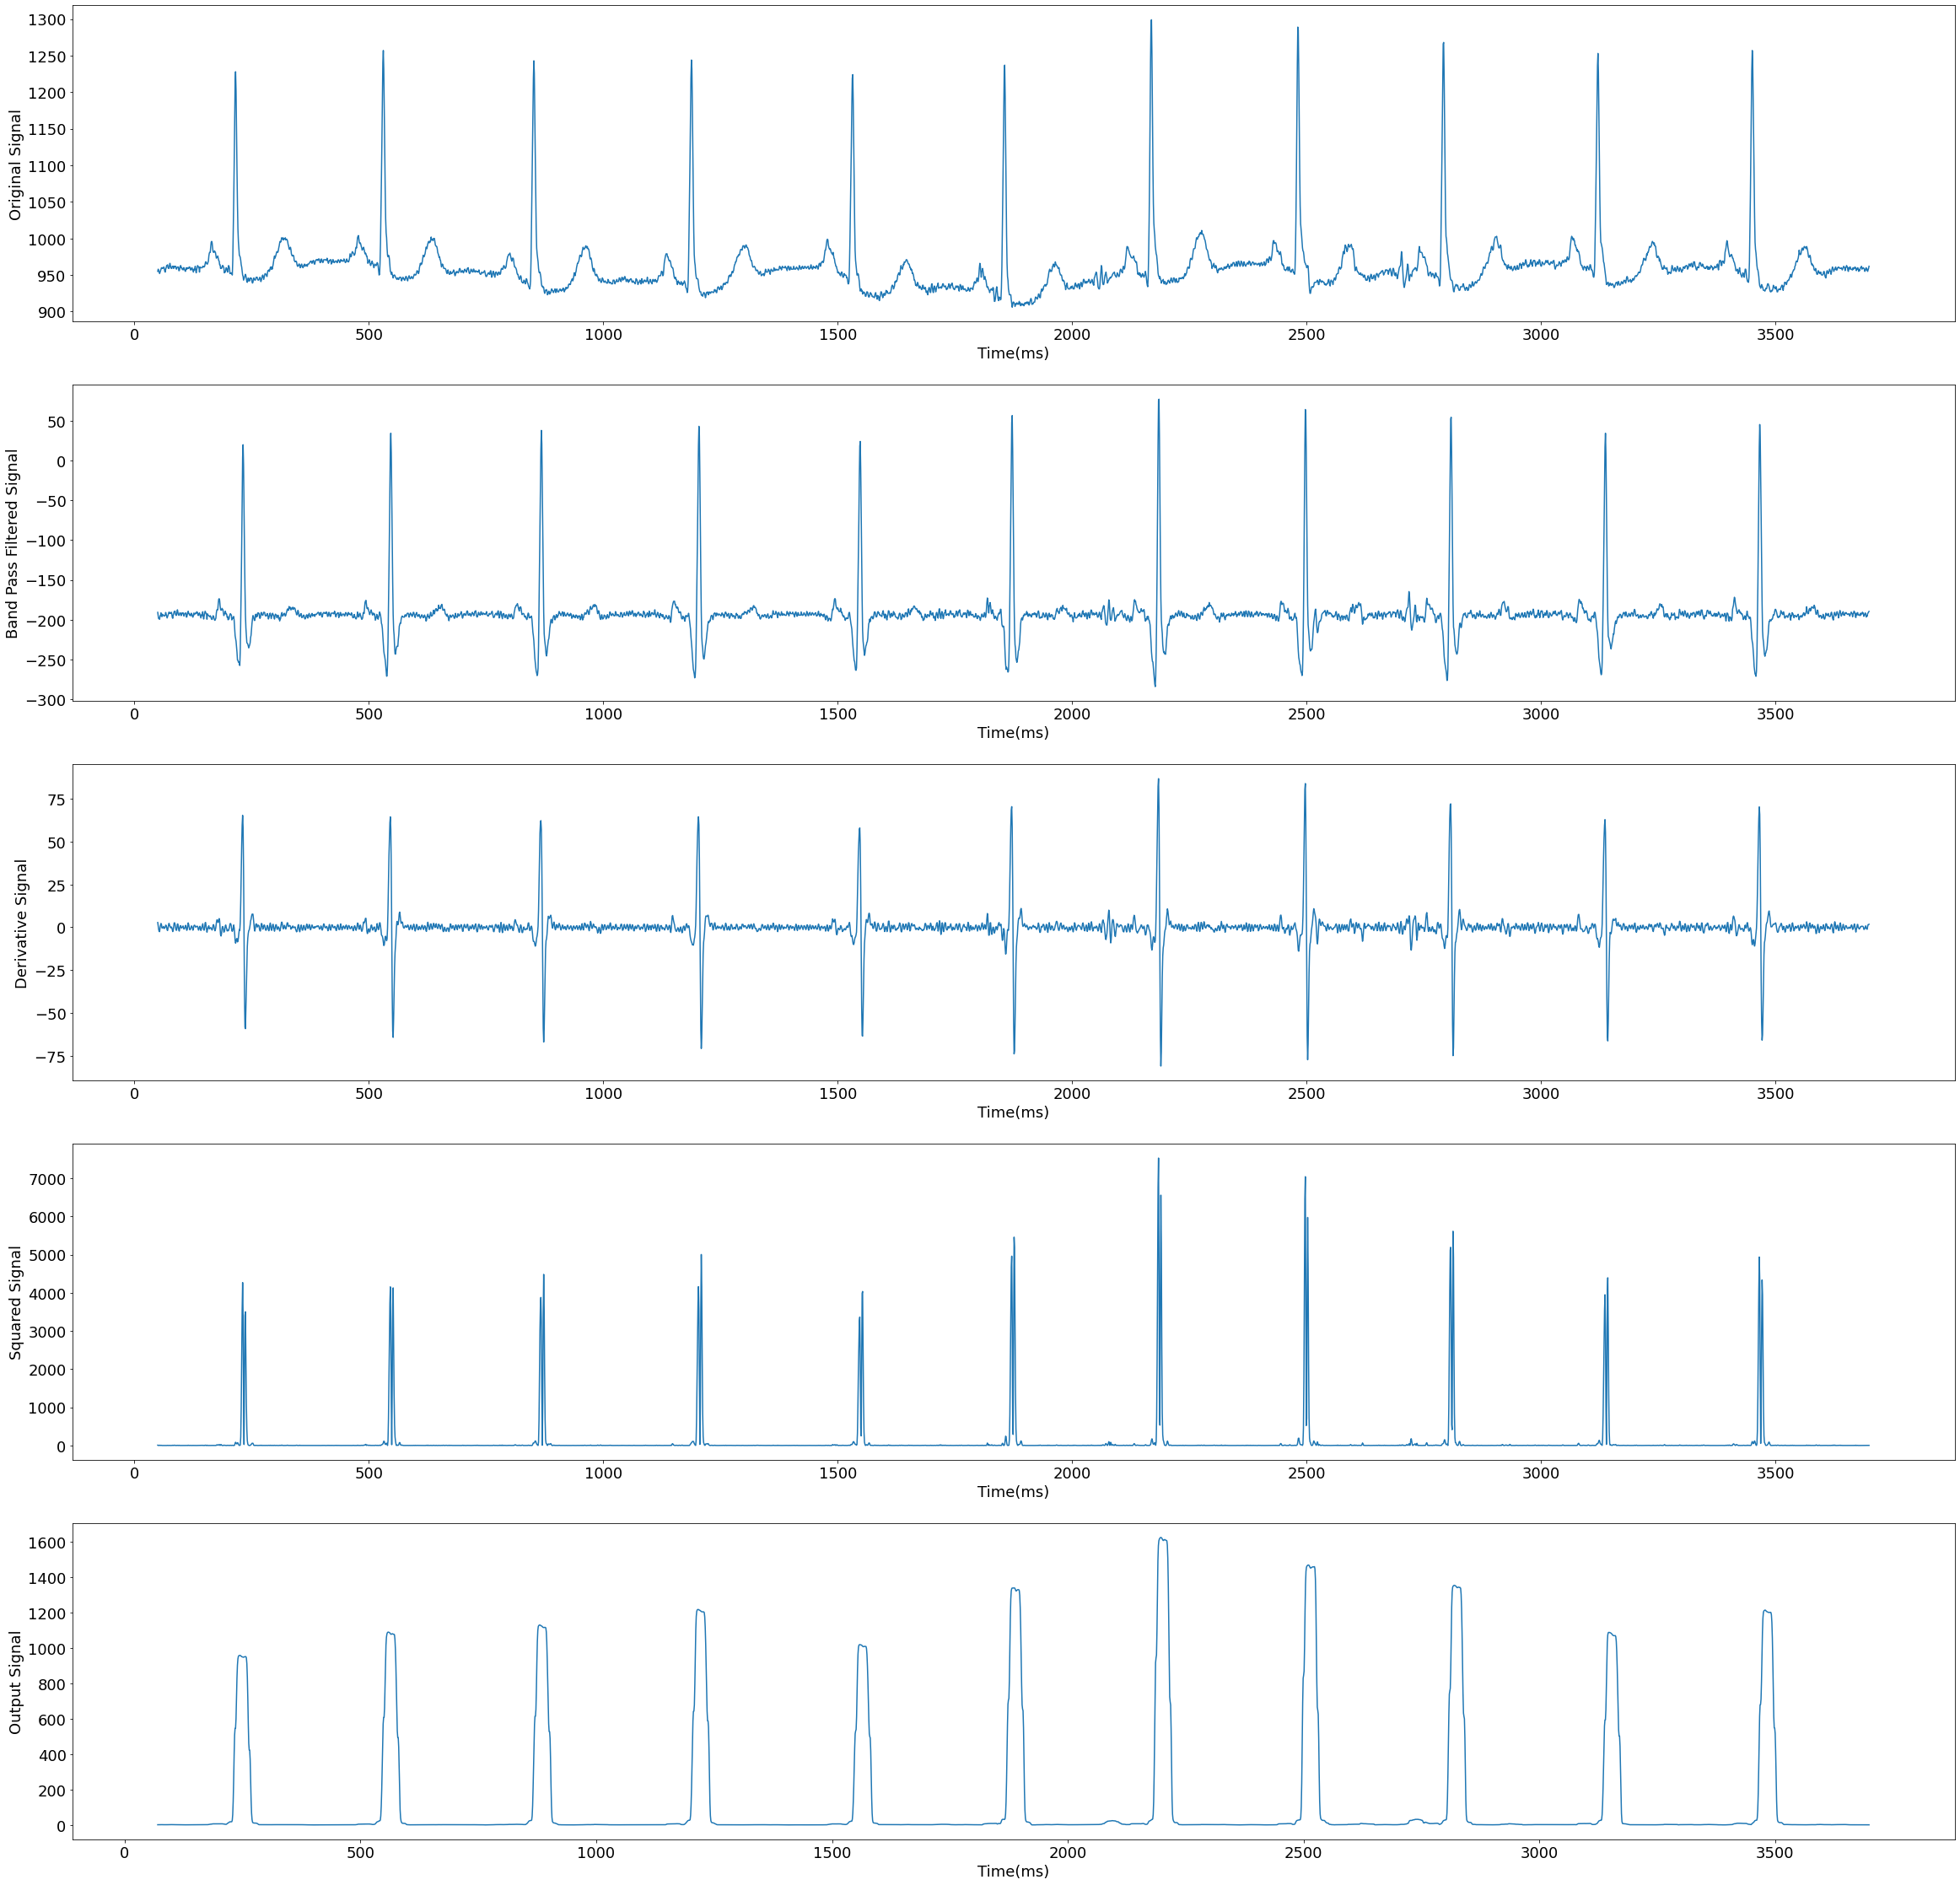

**Signal 2**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 100.73280385047869 beats per minute.

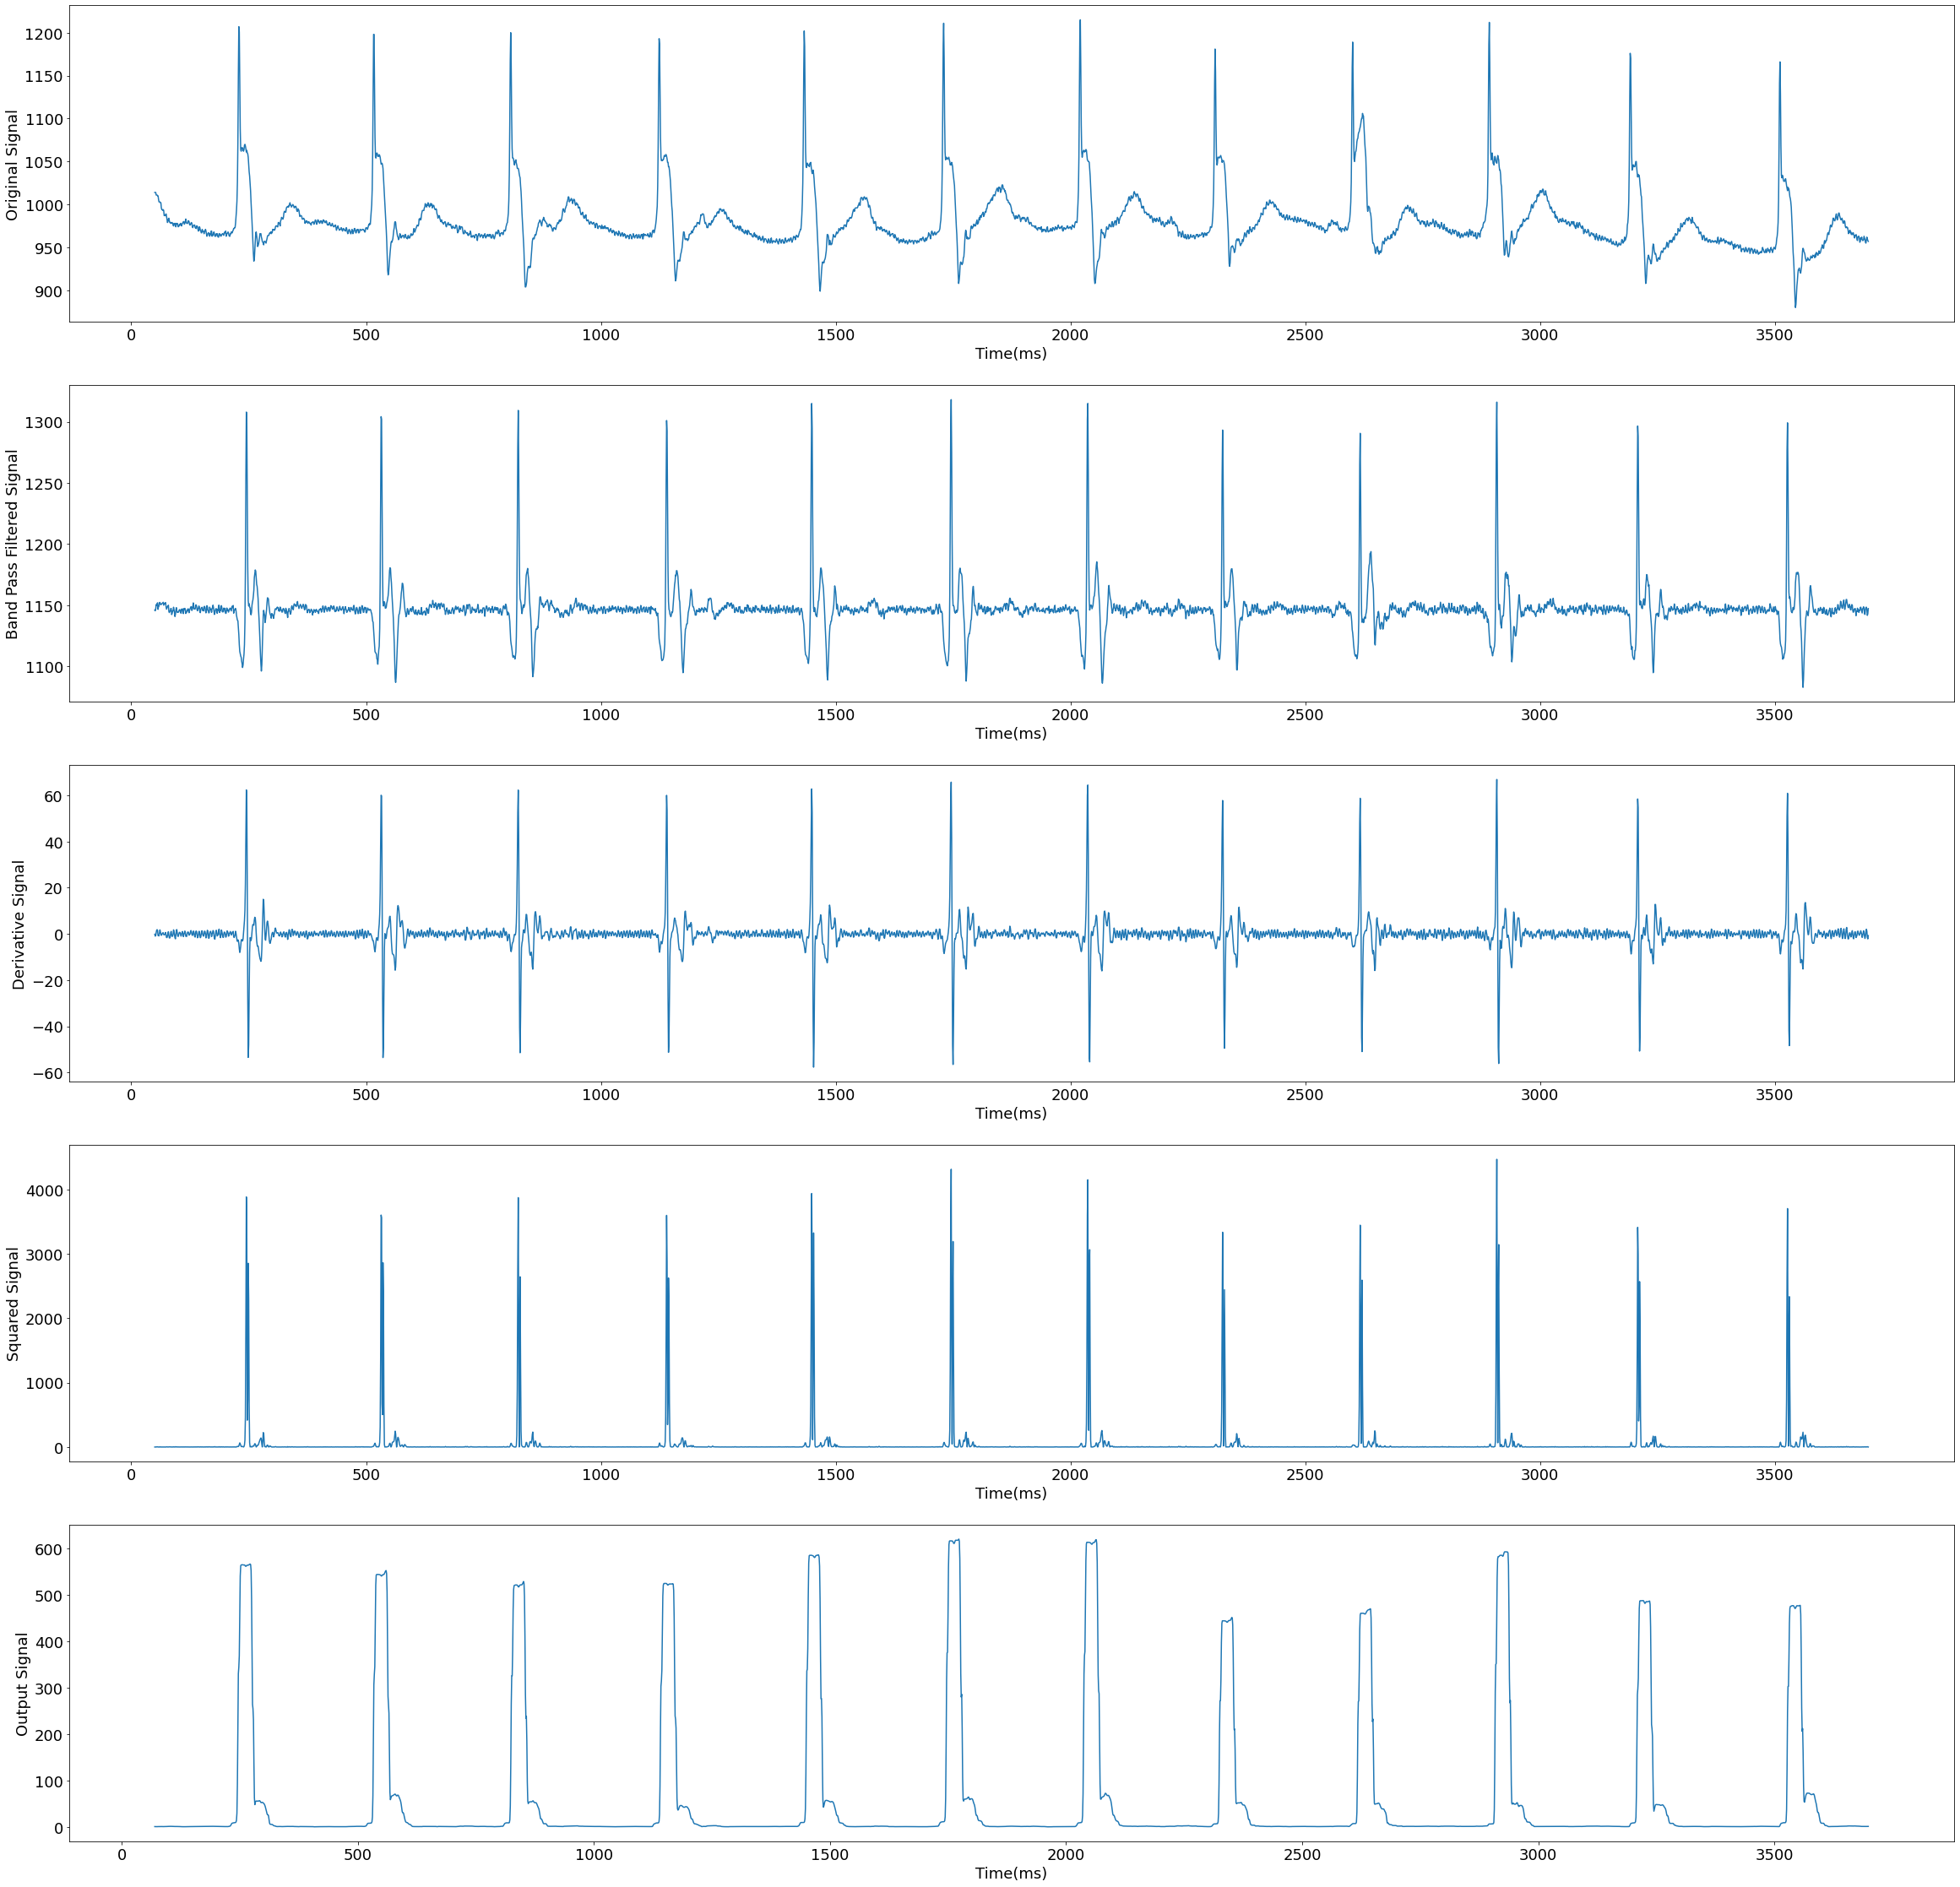

**Signal 3**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 97.87629830197383 beats per minute.

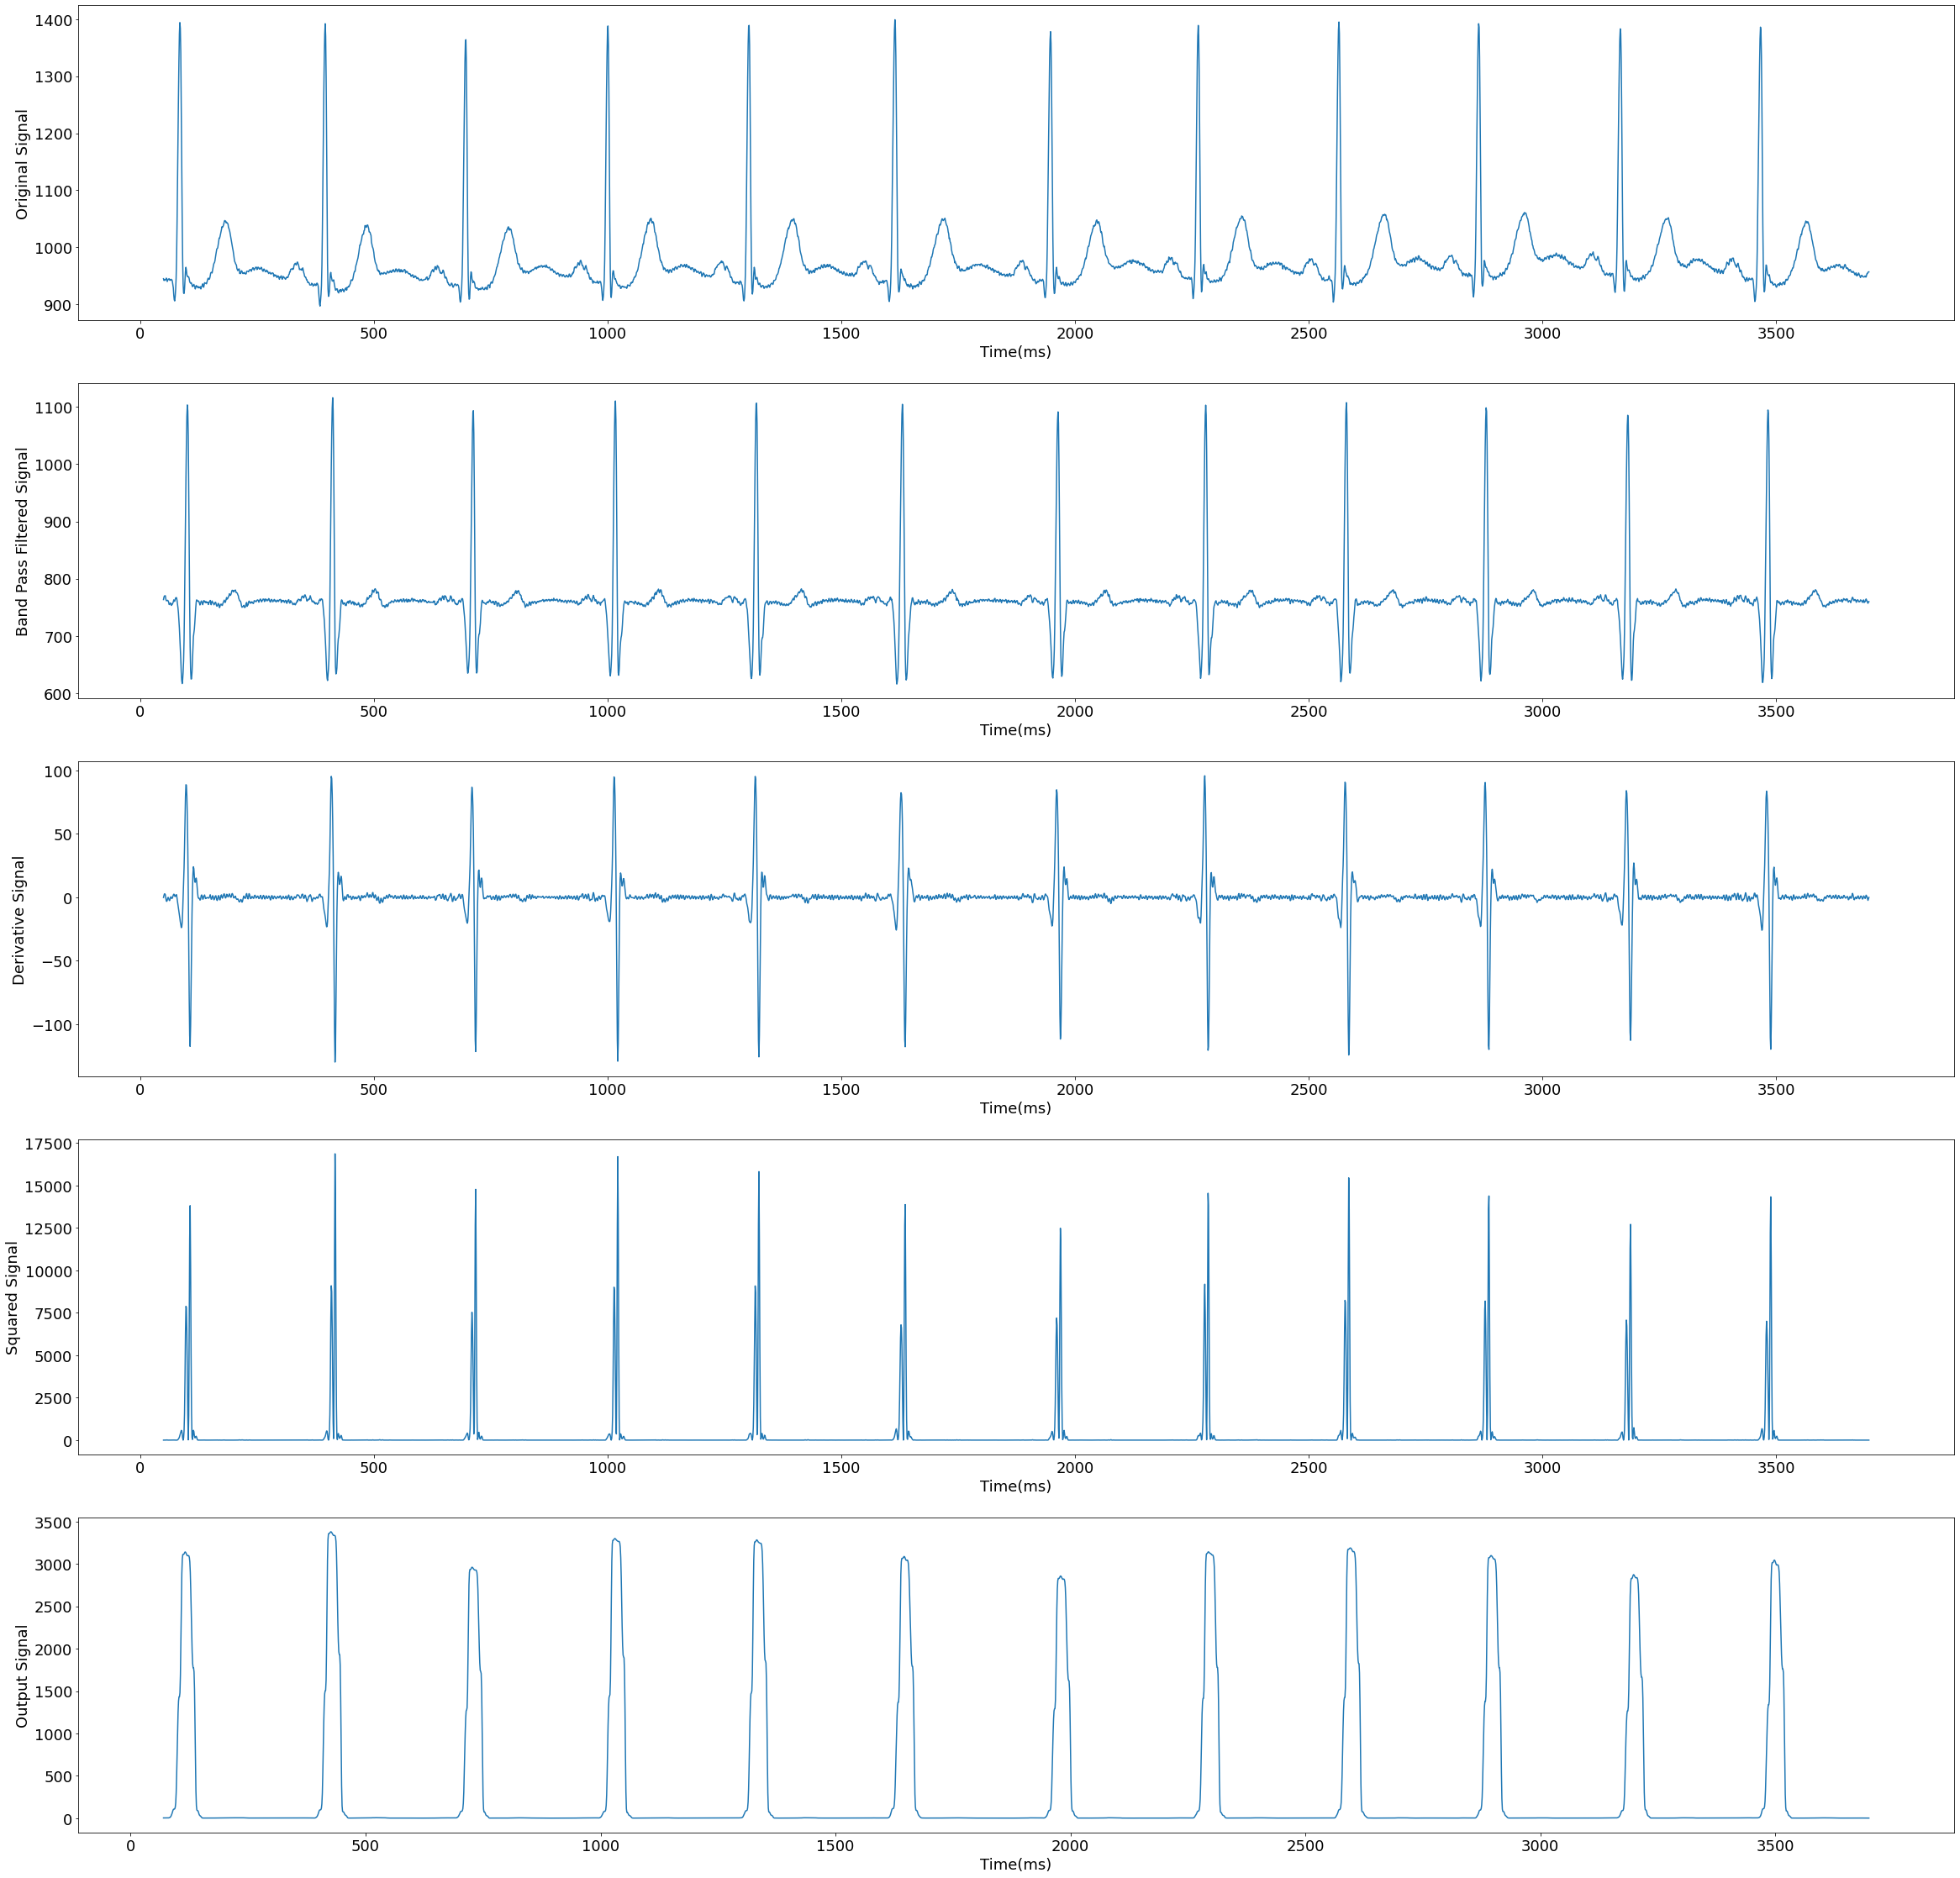

**Signal 4**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 103.36297726577956 beats per minute.

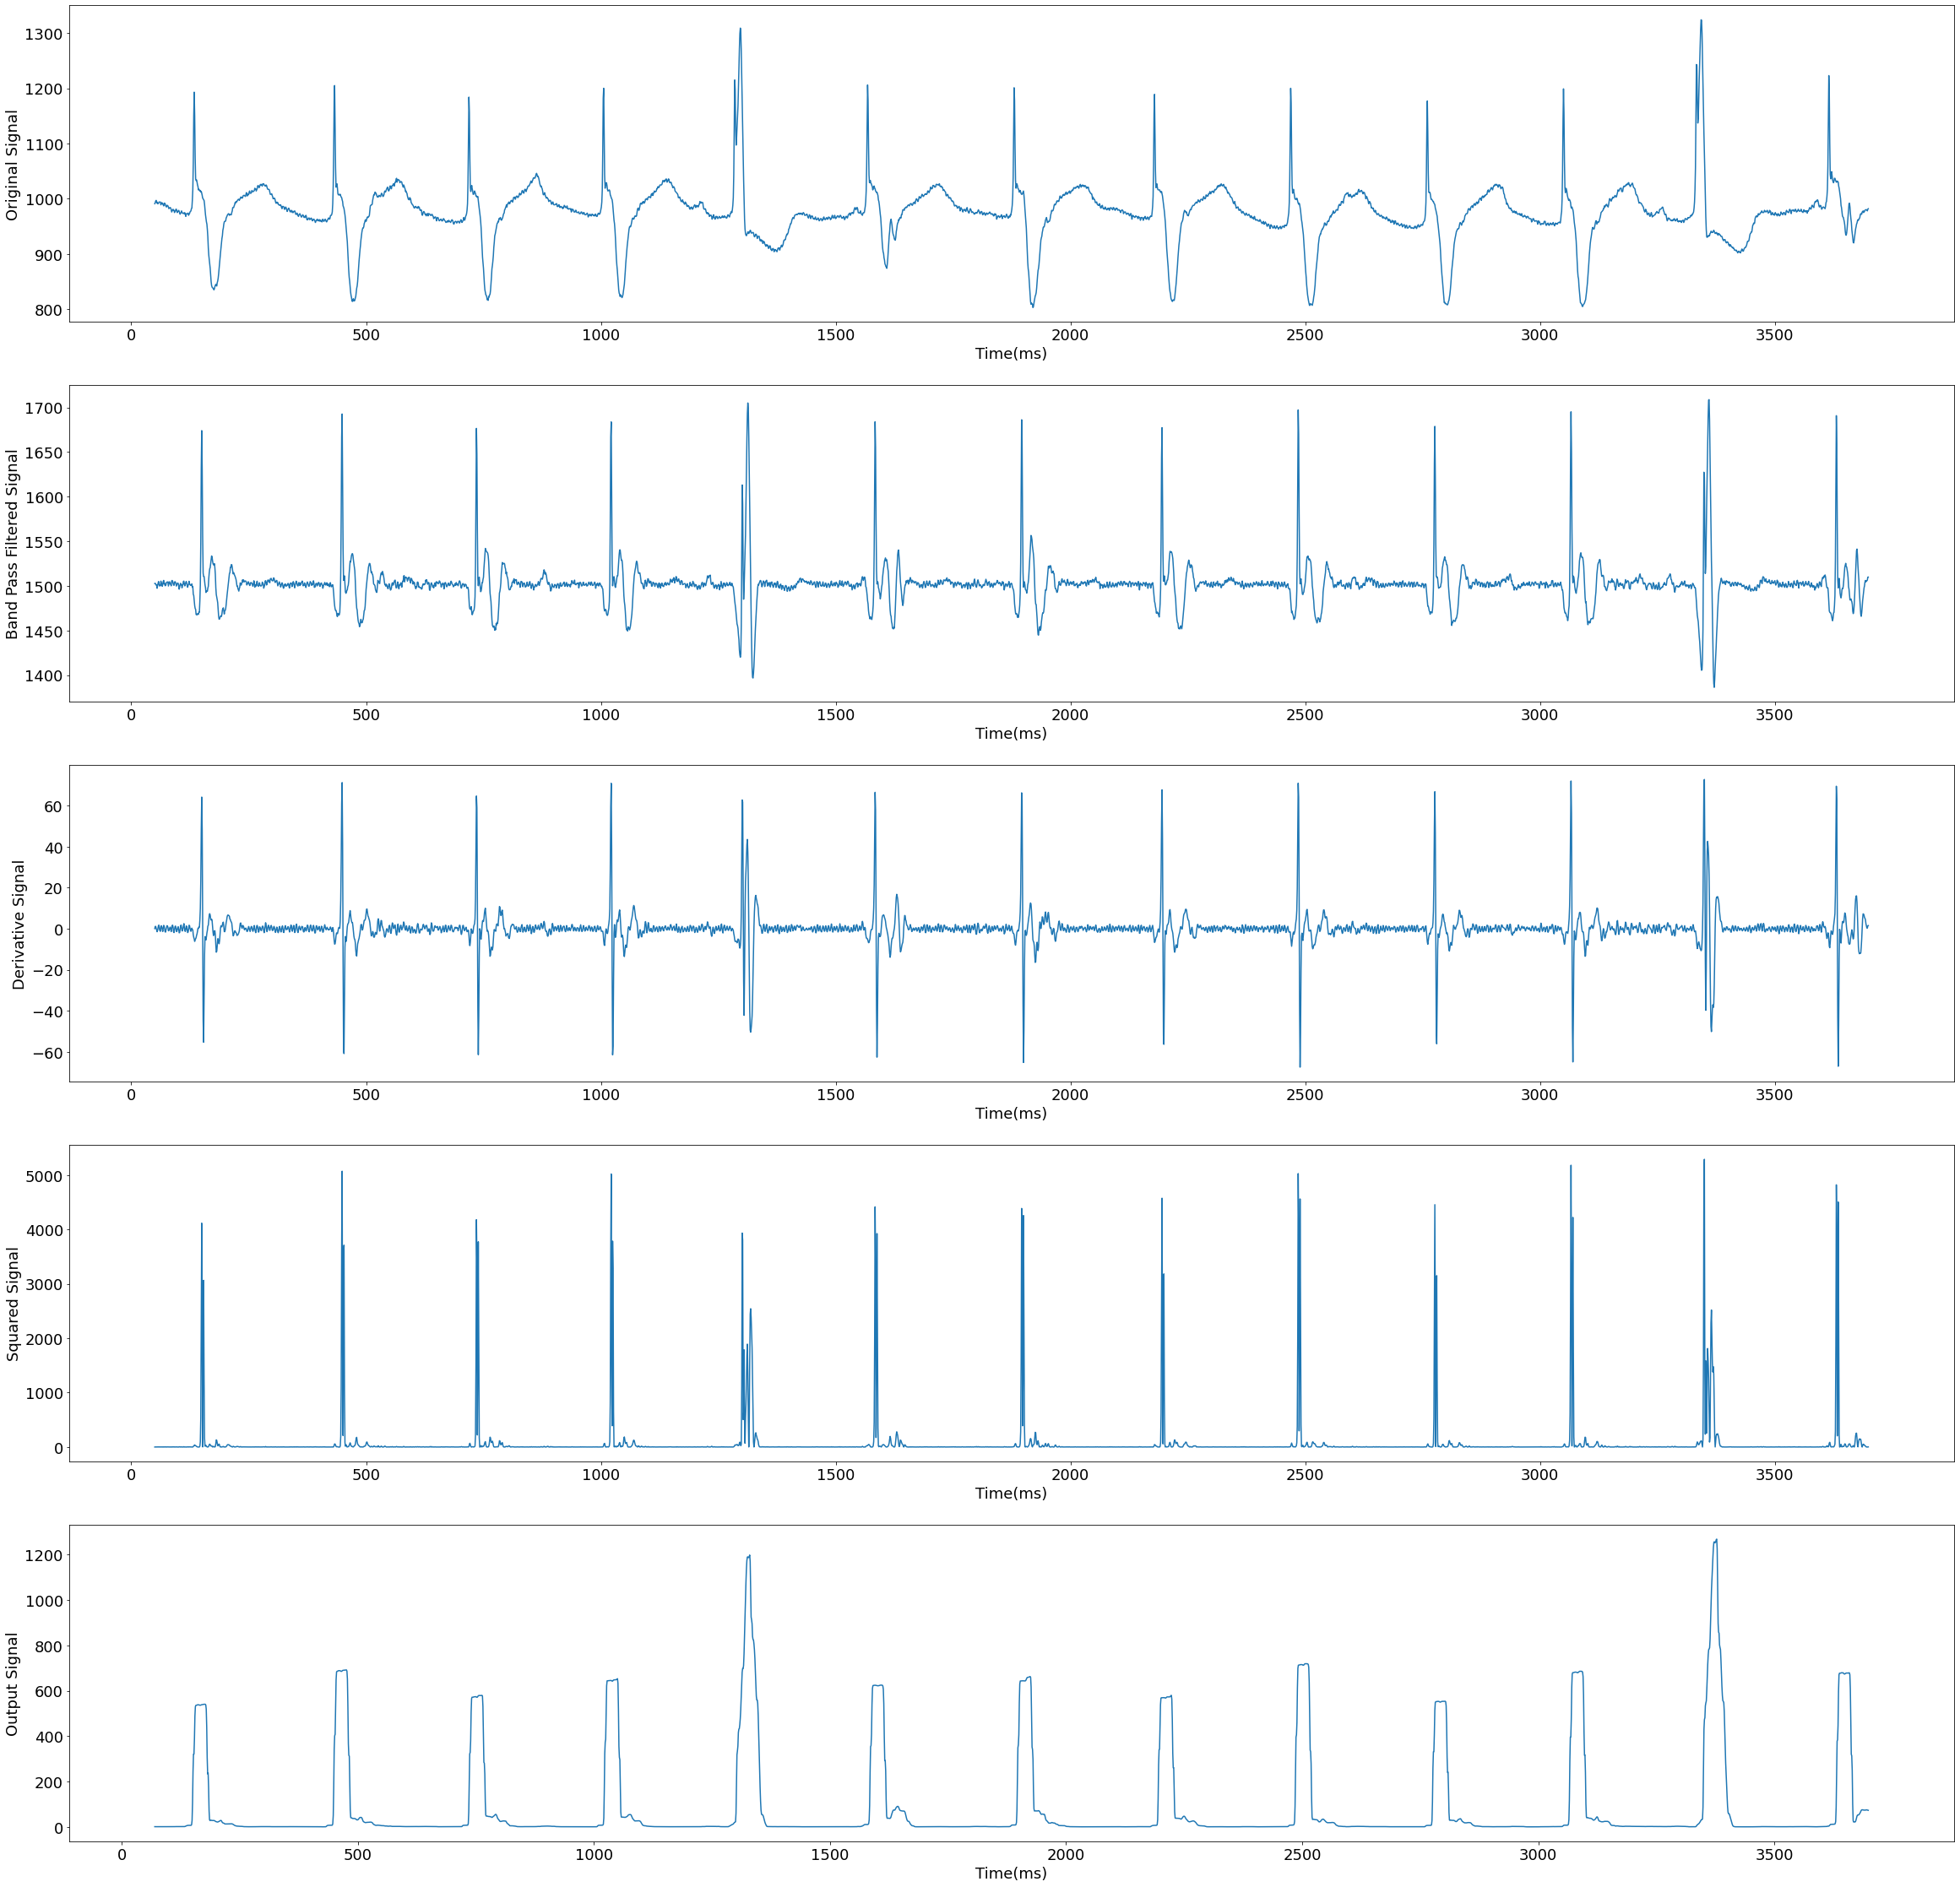

**Signal 5**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 115.74178974524852 beats per minute.

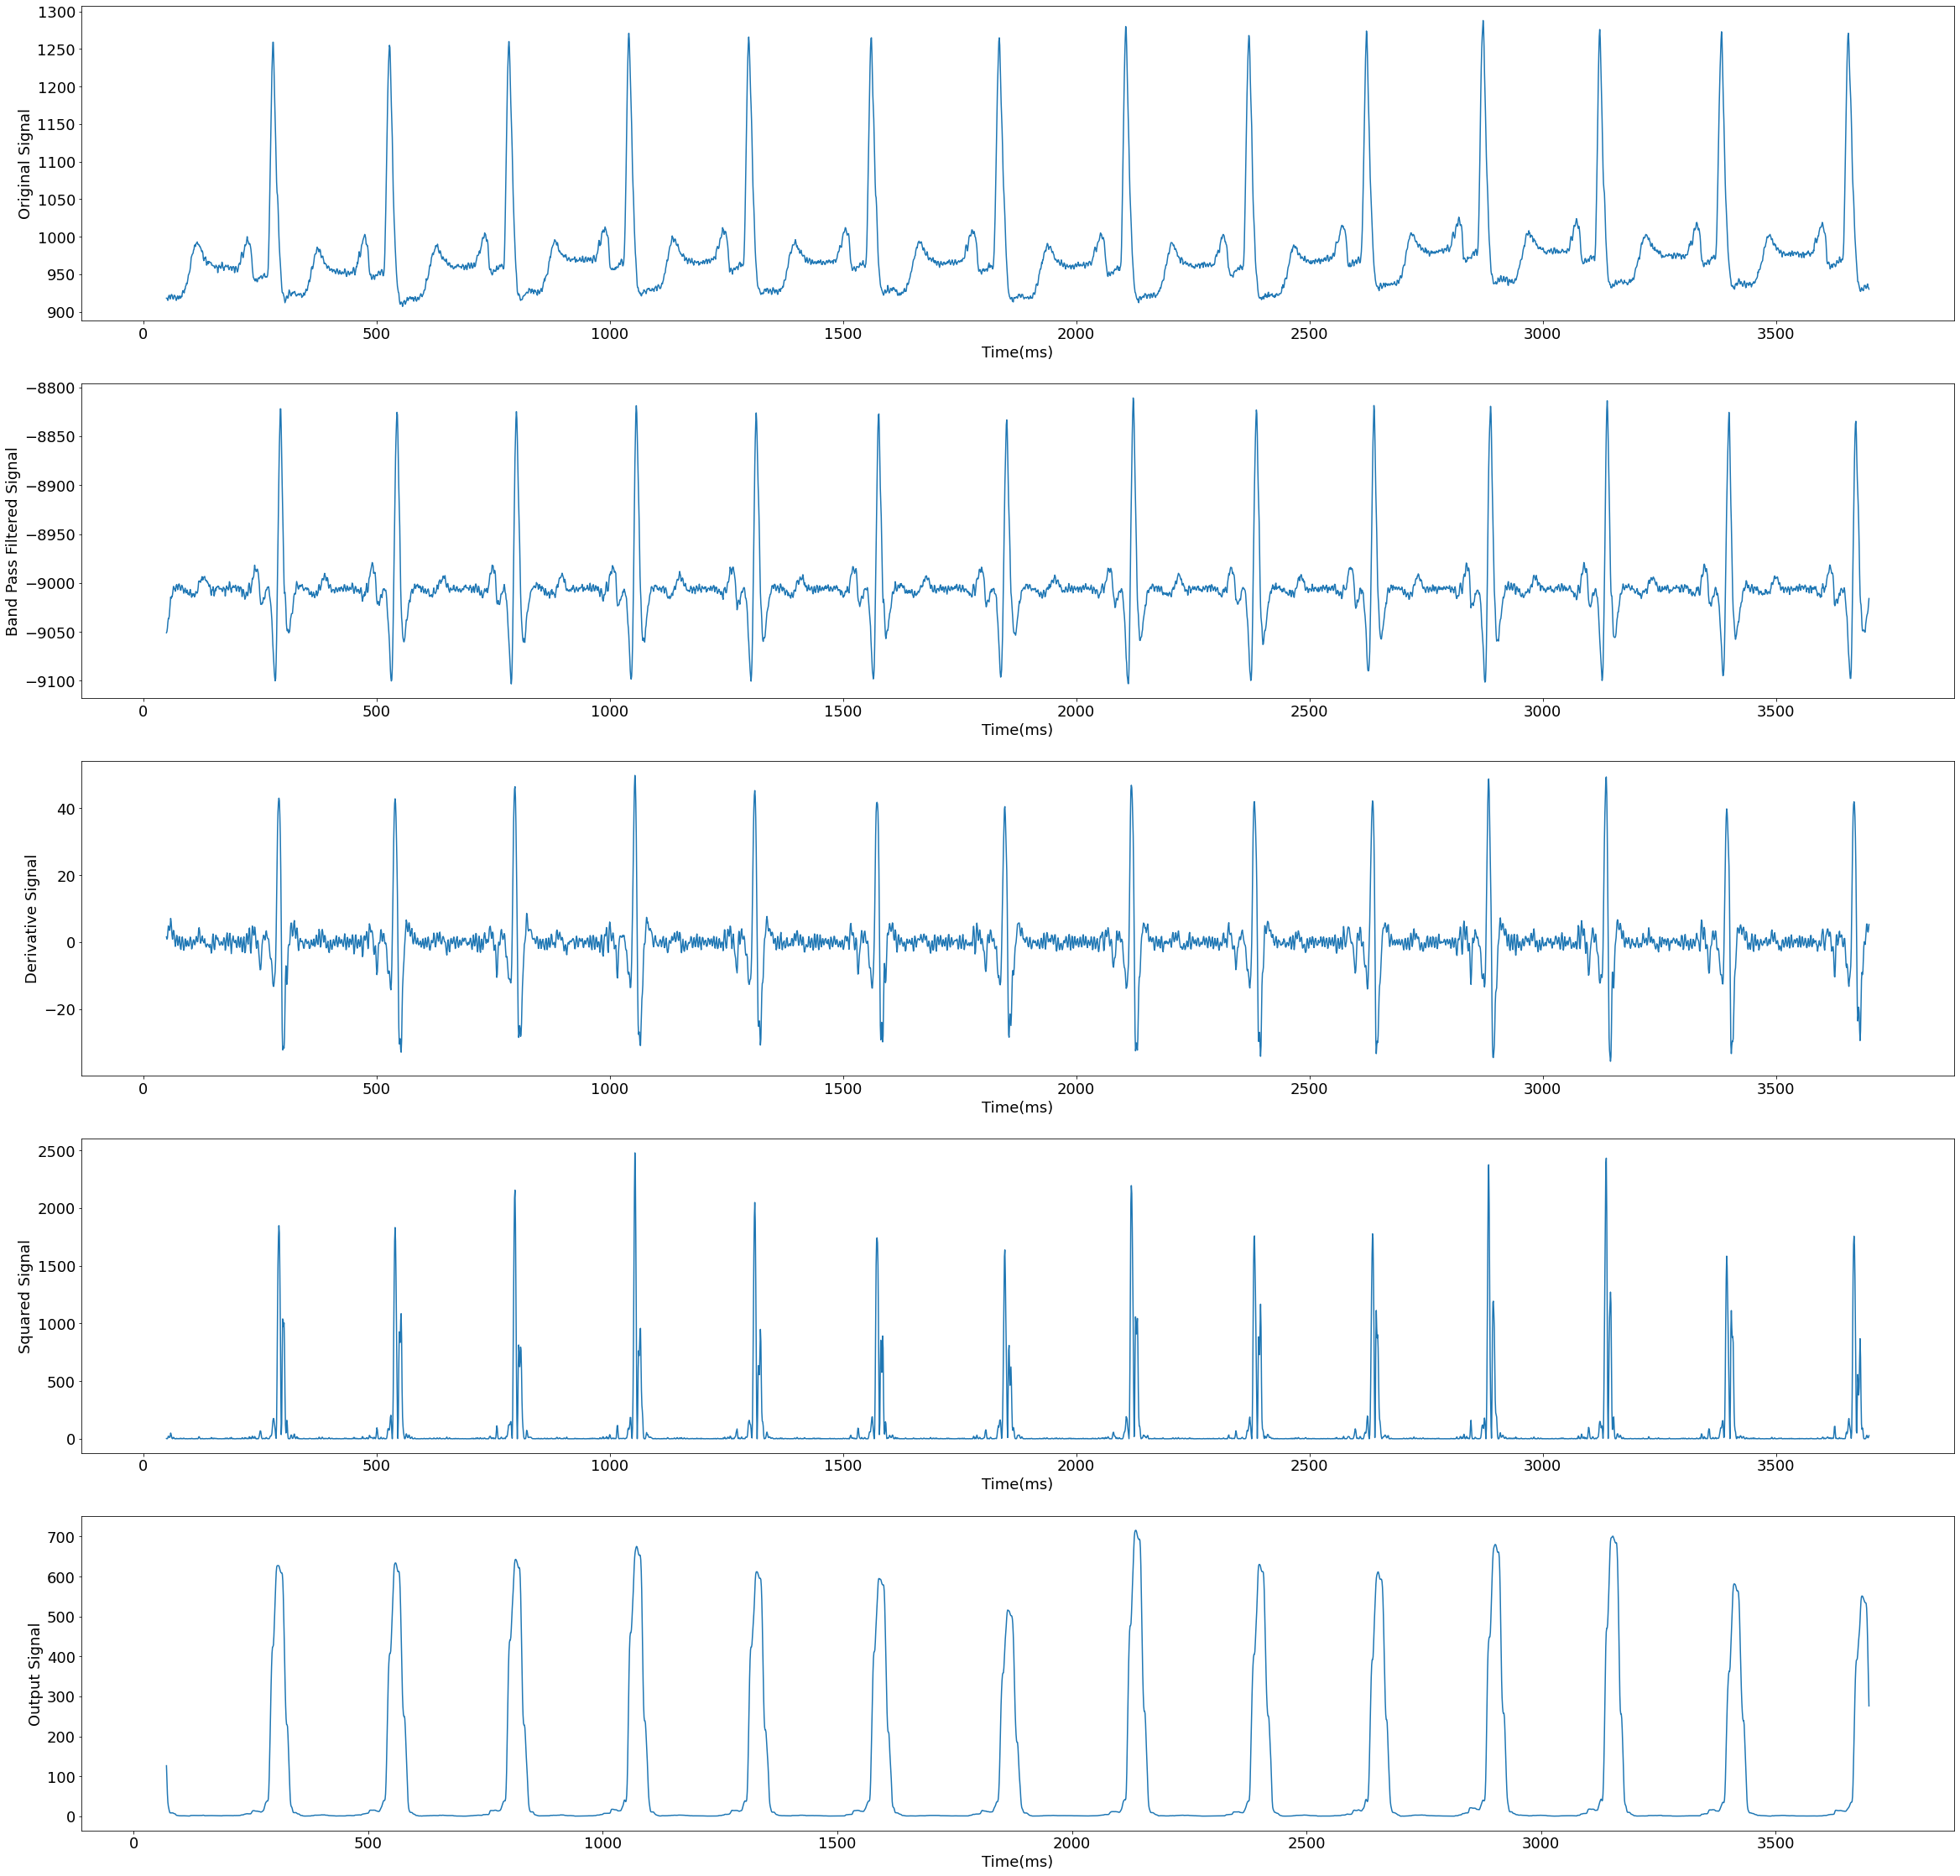

**Signal 6**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 83.93360888377761 beats per minute

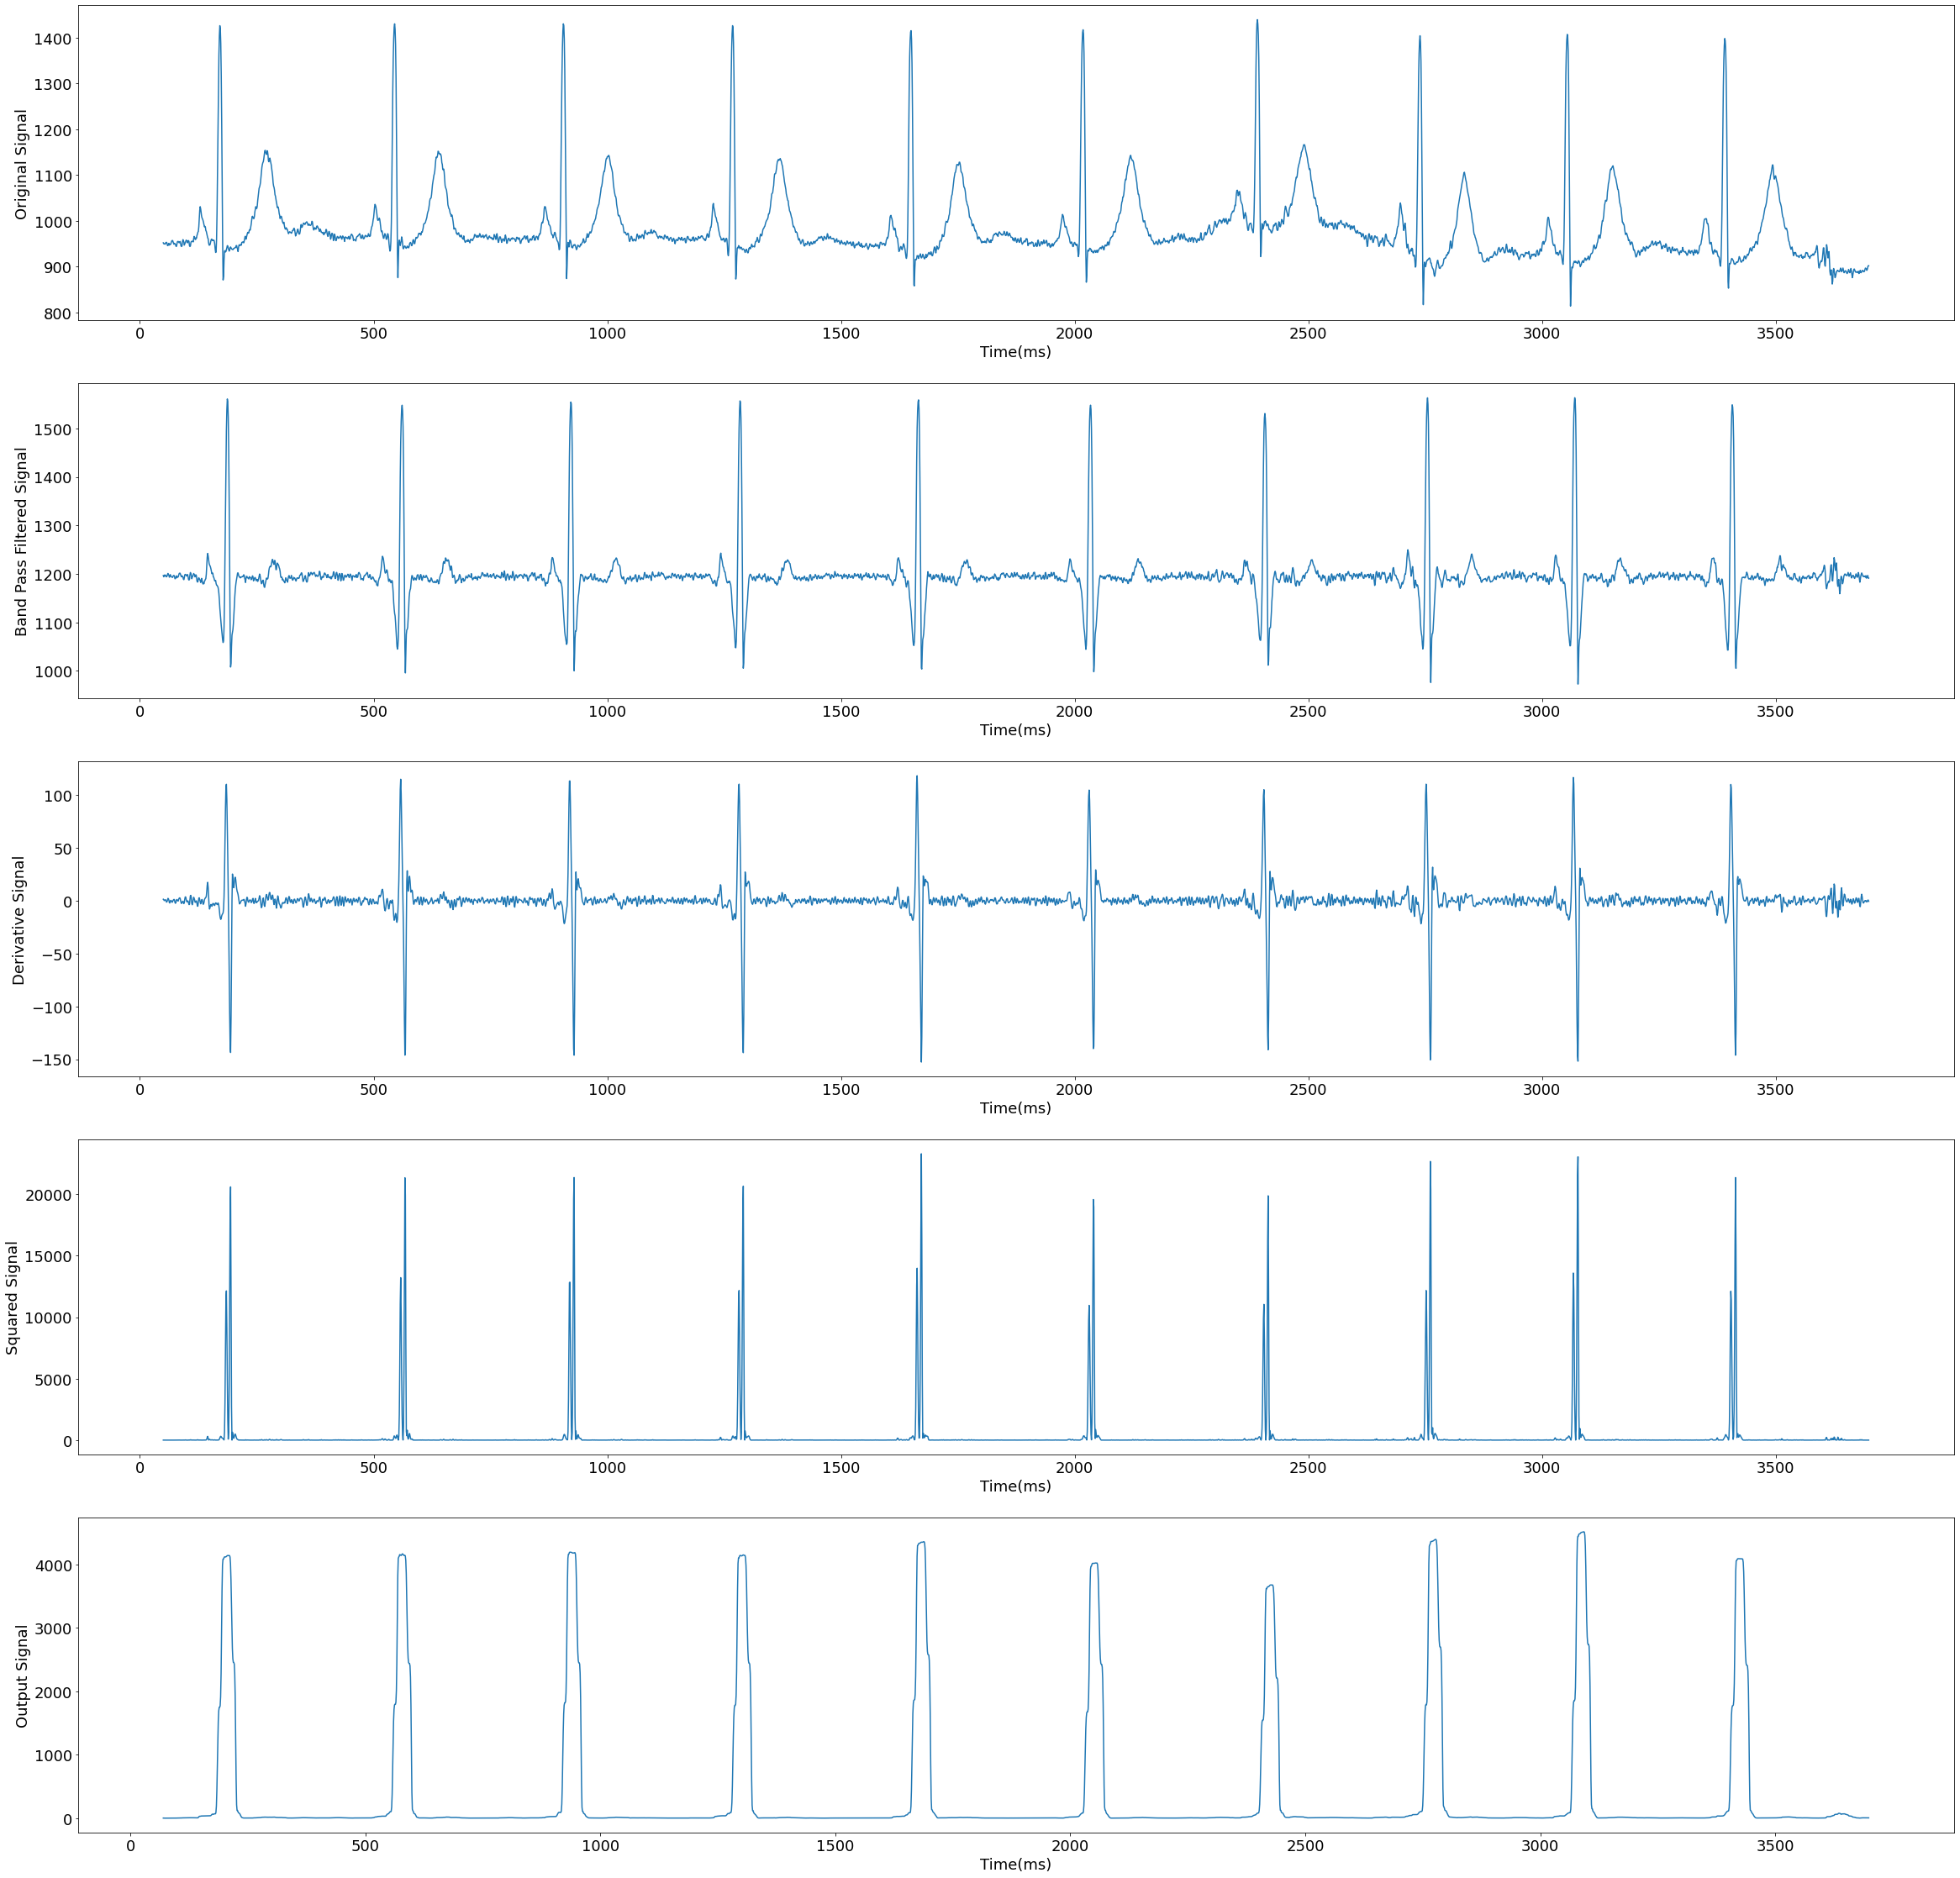

**Signal 7**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 97.35961039400118 beats per minute.

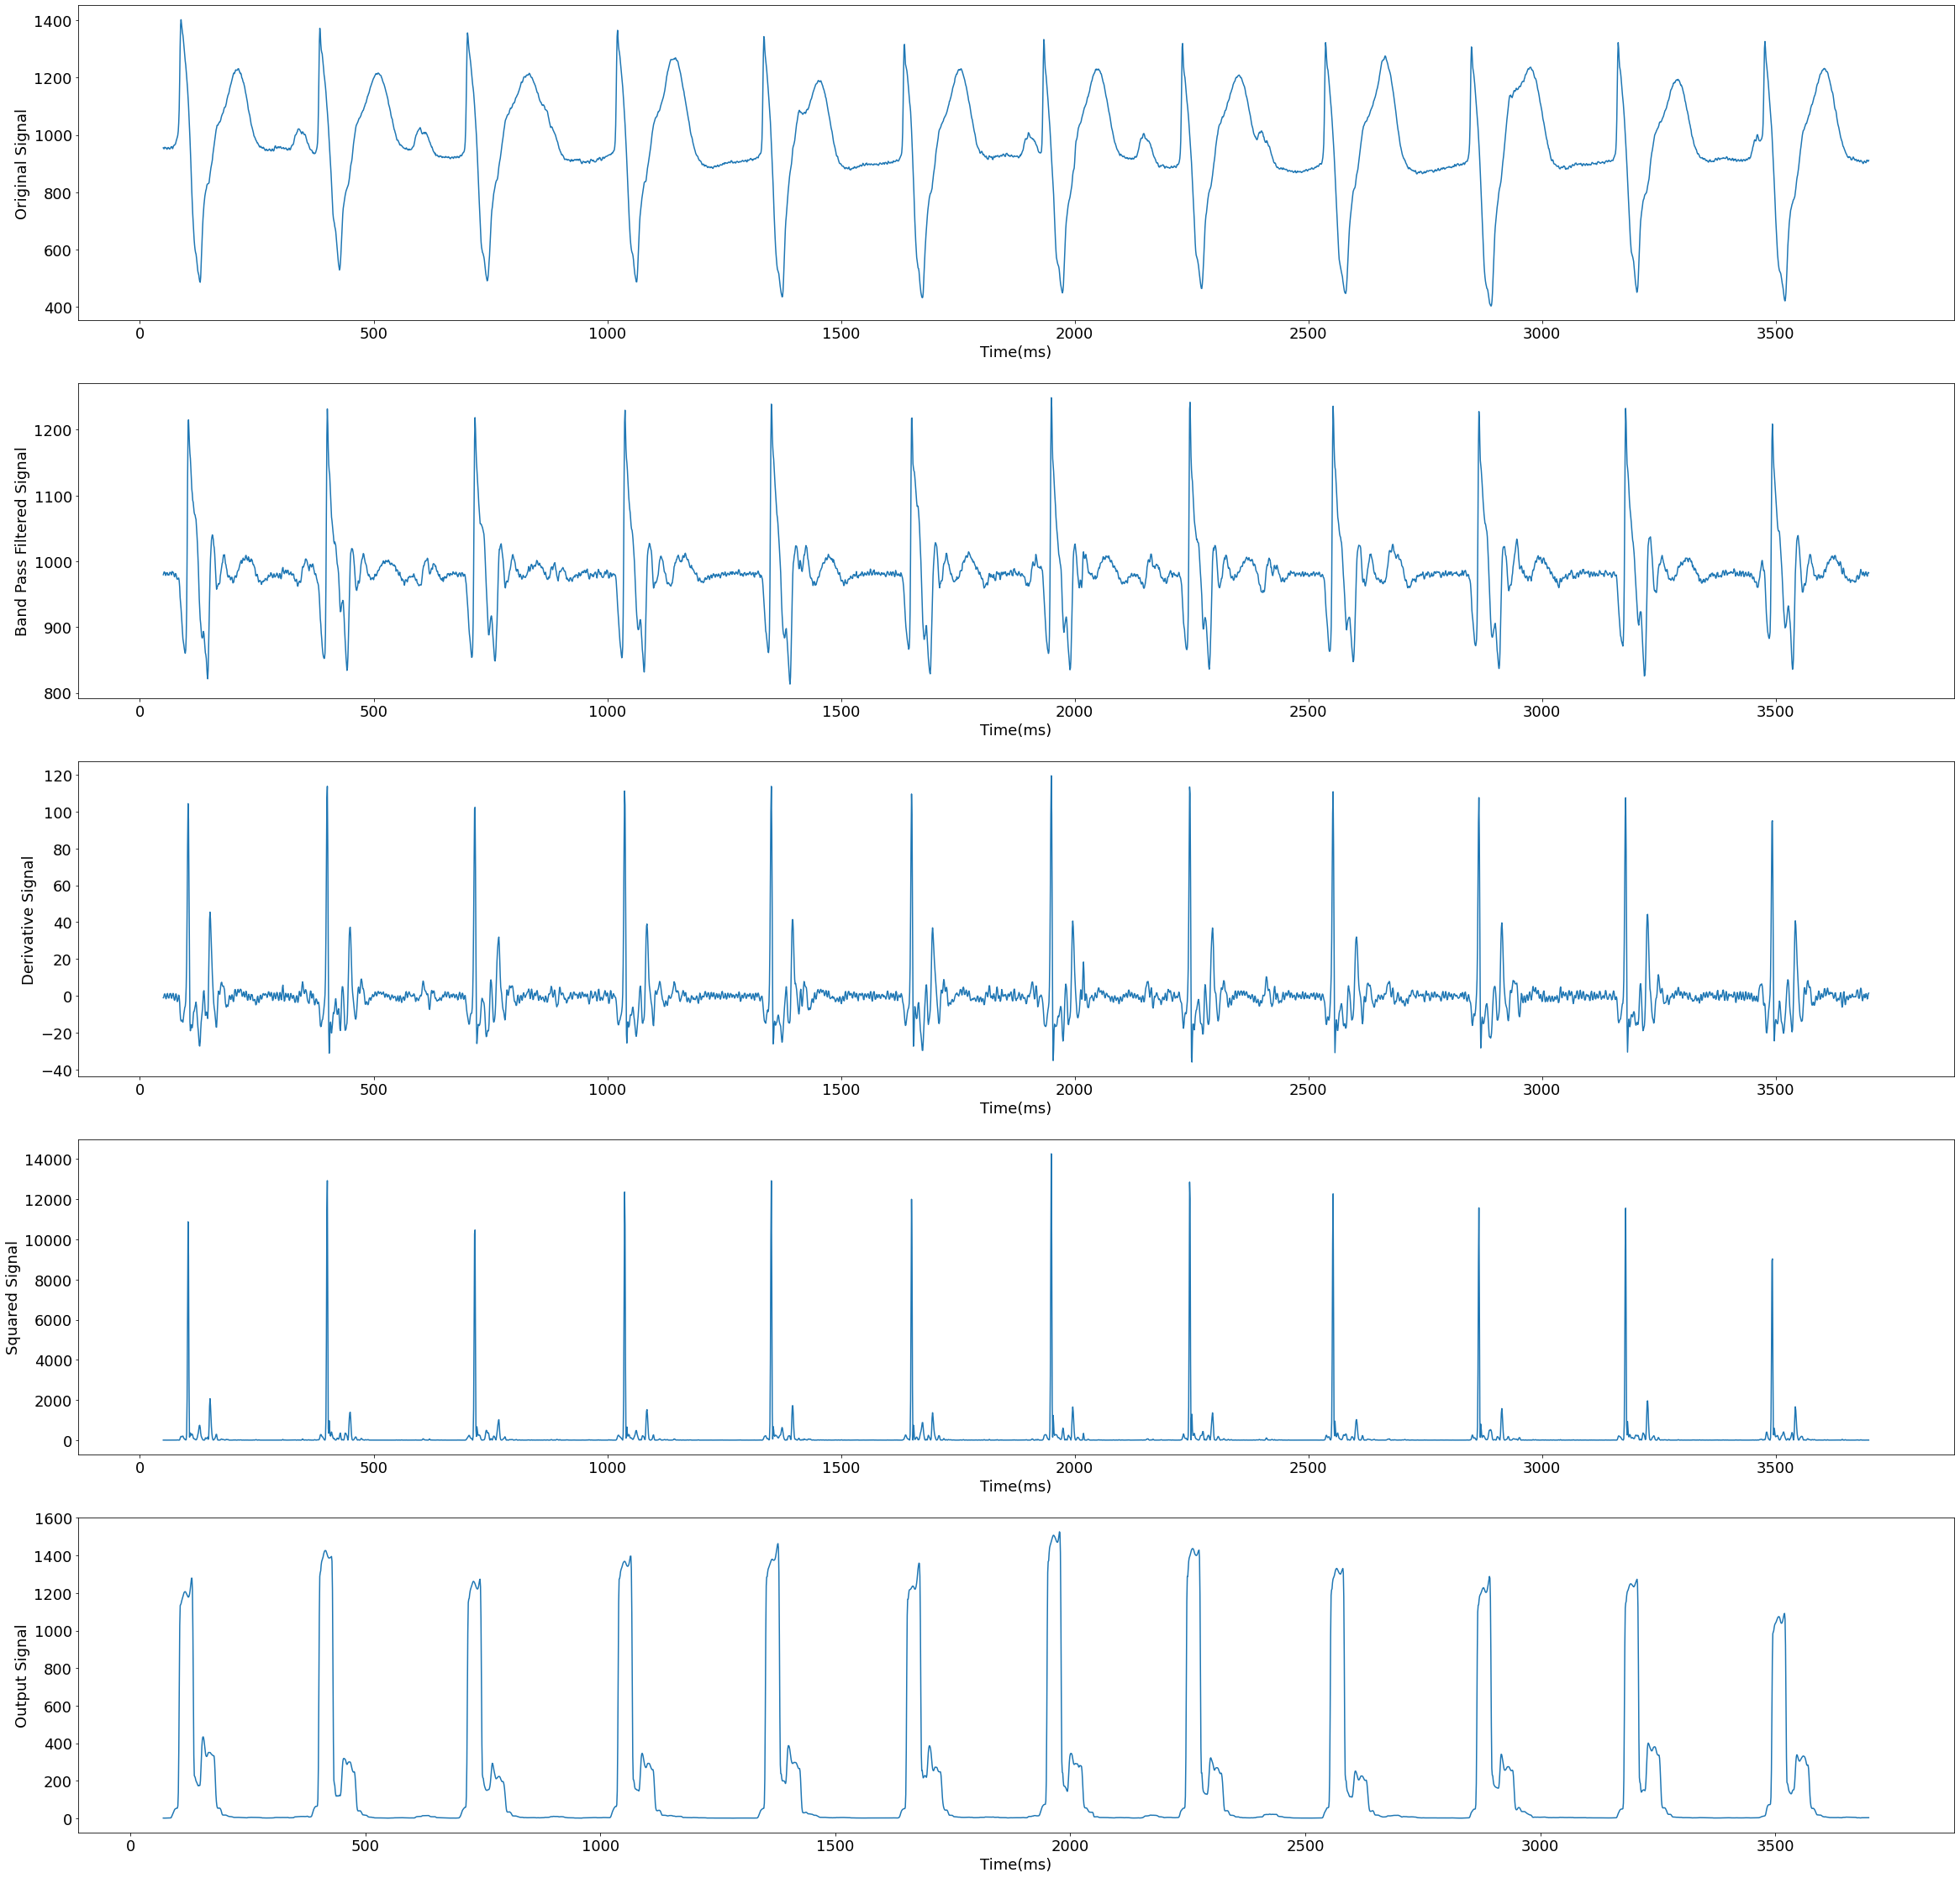

**Signal 8**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 143.21935883818315 beats per minute.

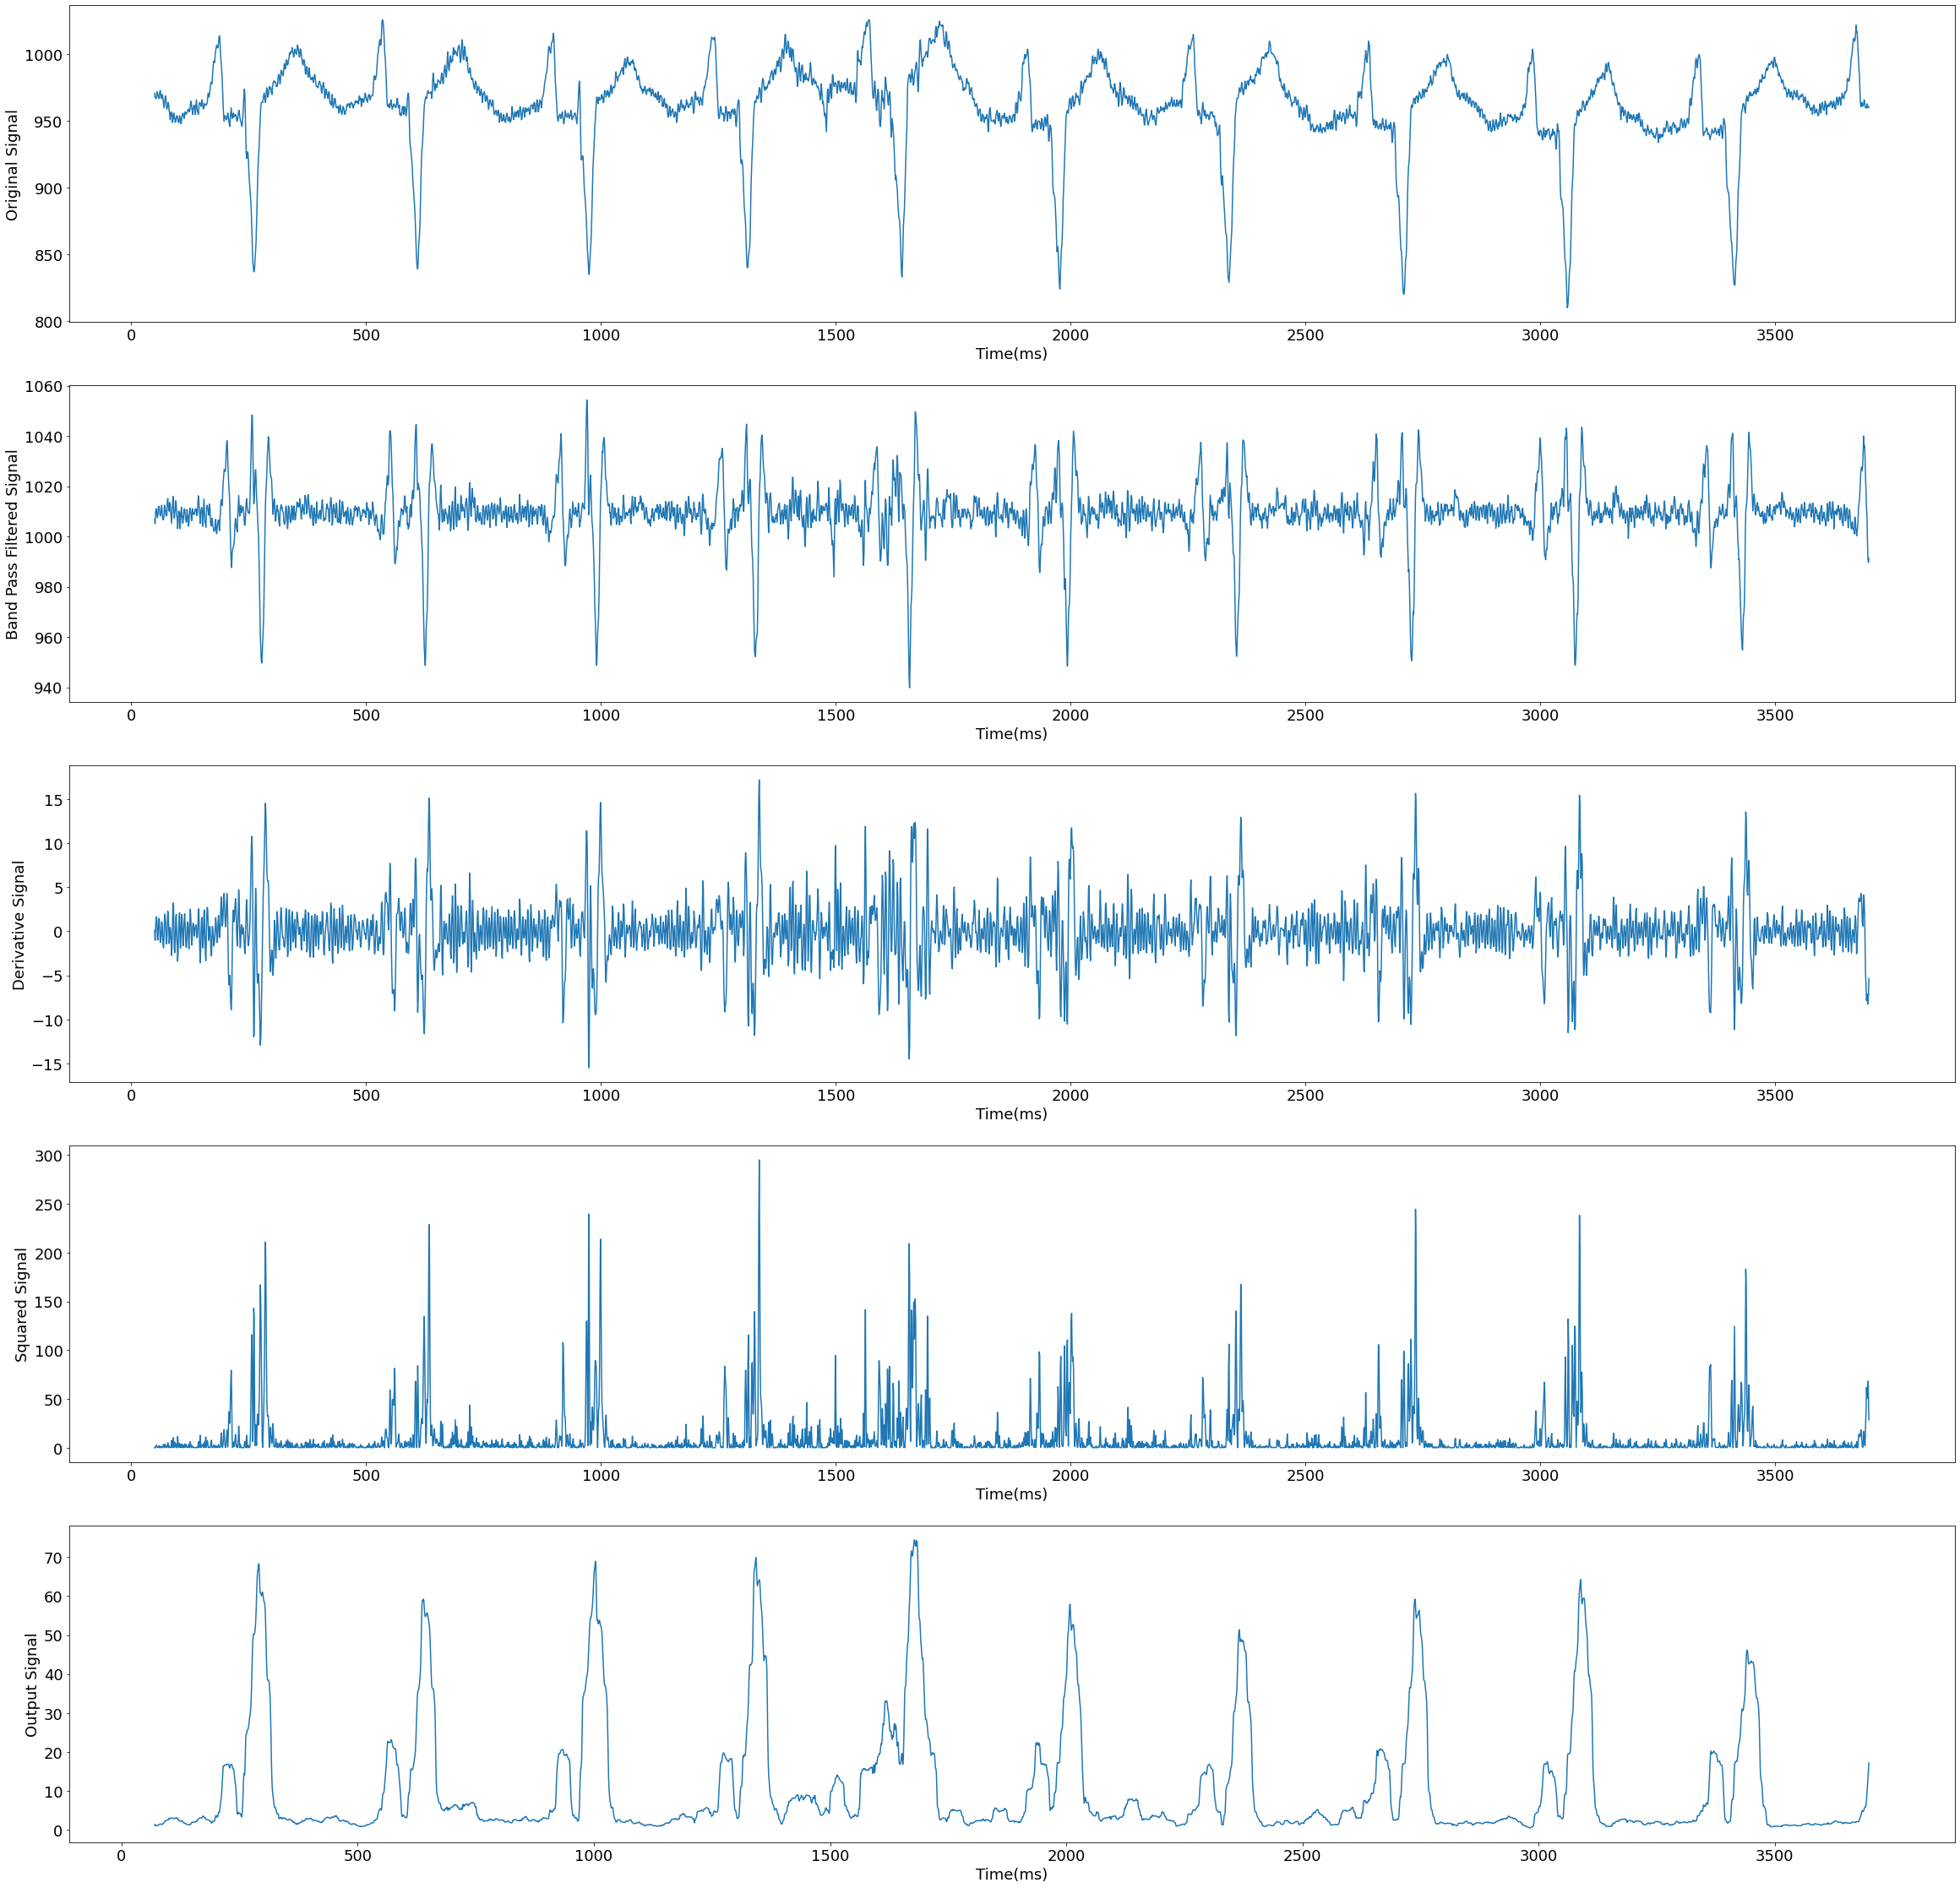

**Signal 9**

Heart Rate as calculated according to the Pan-Tompkins Algorithm is : 133.62243535880856 beats per minute.

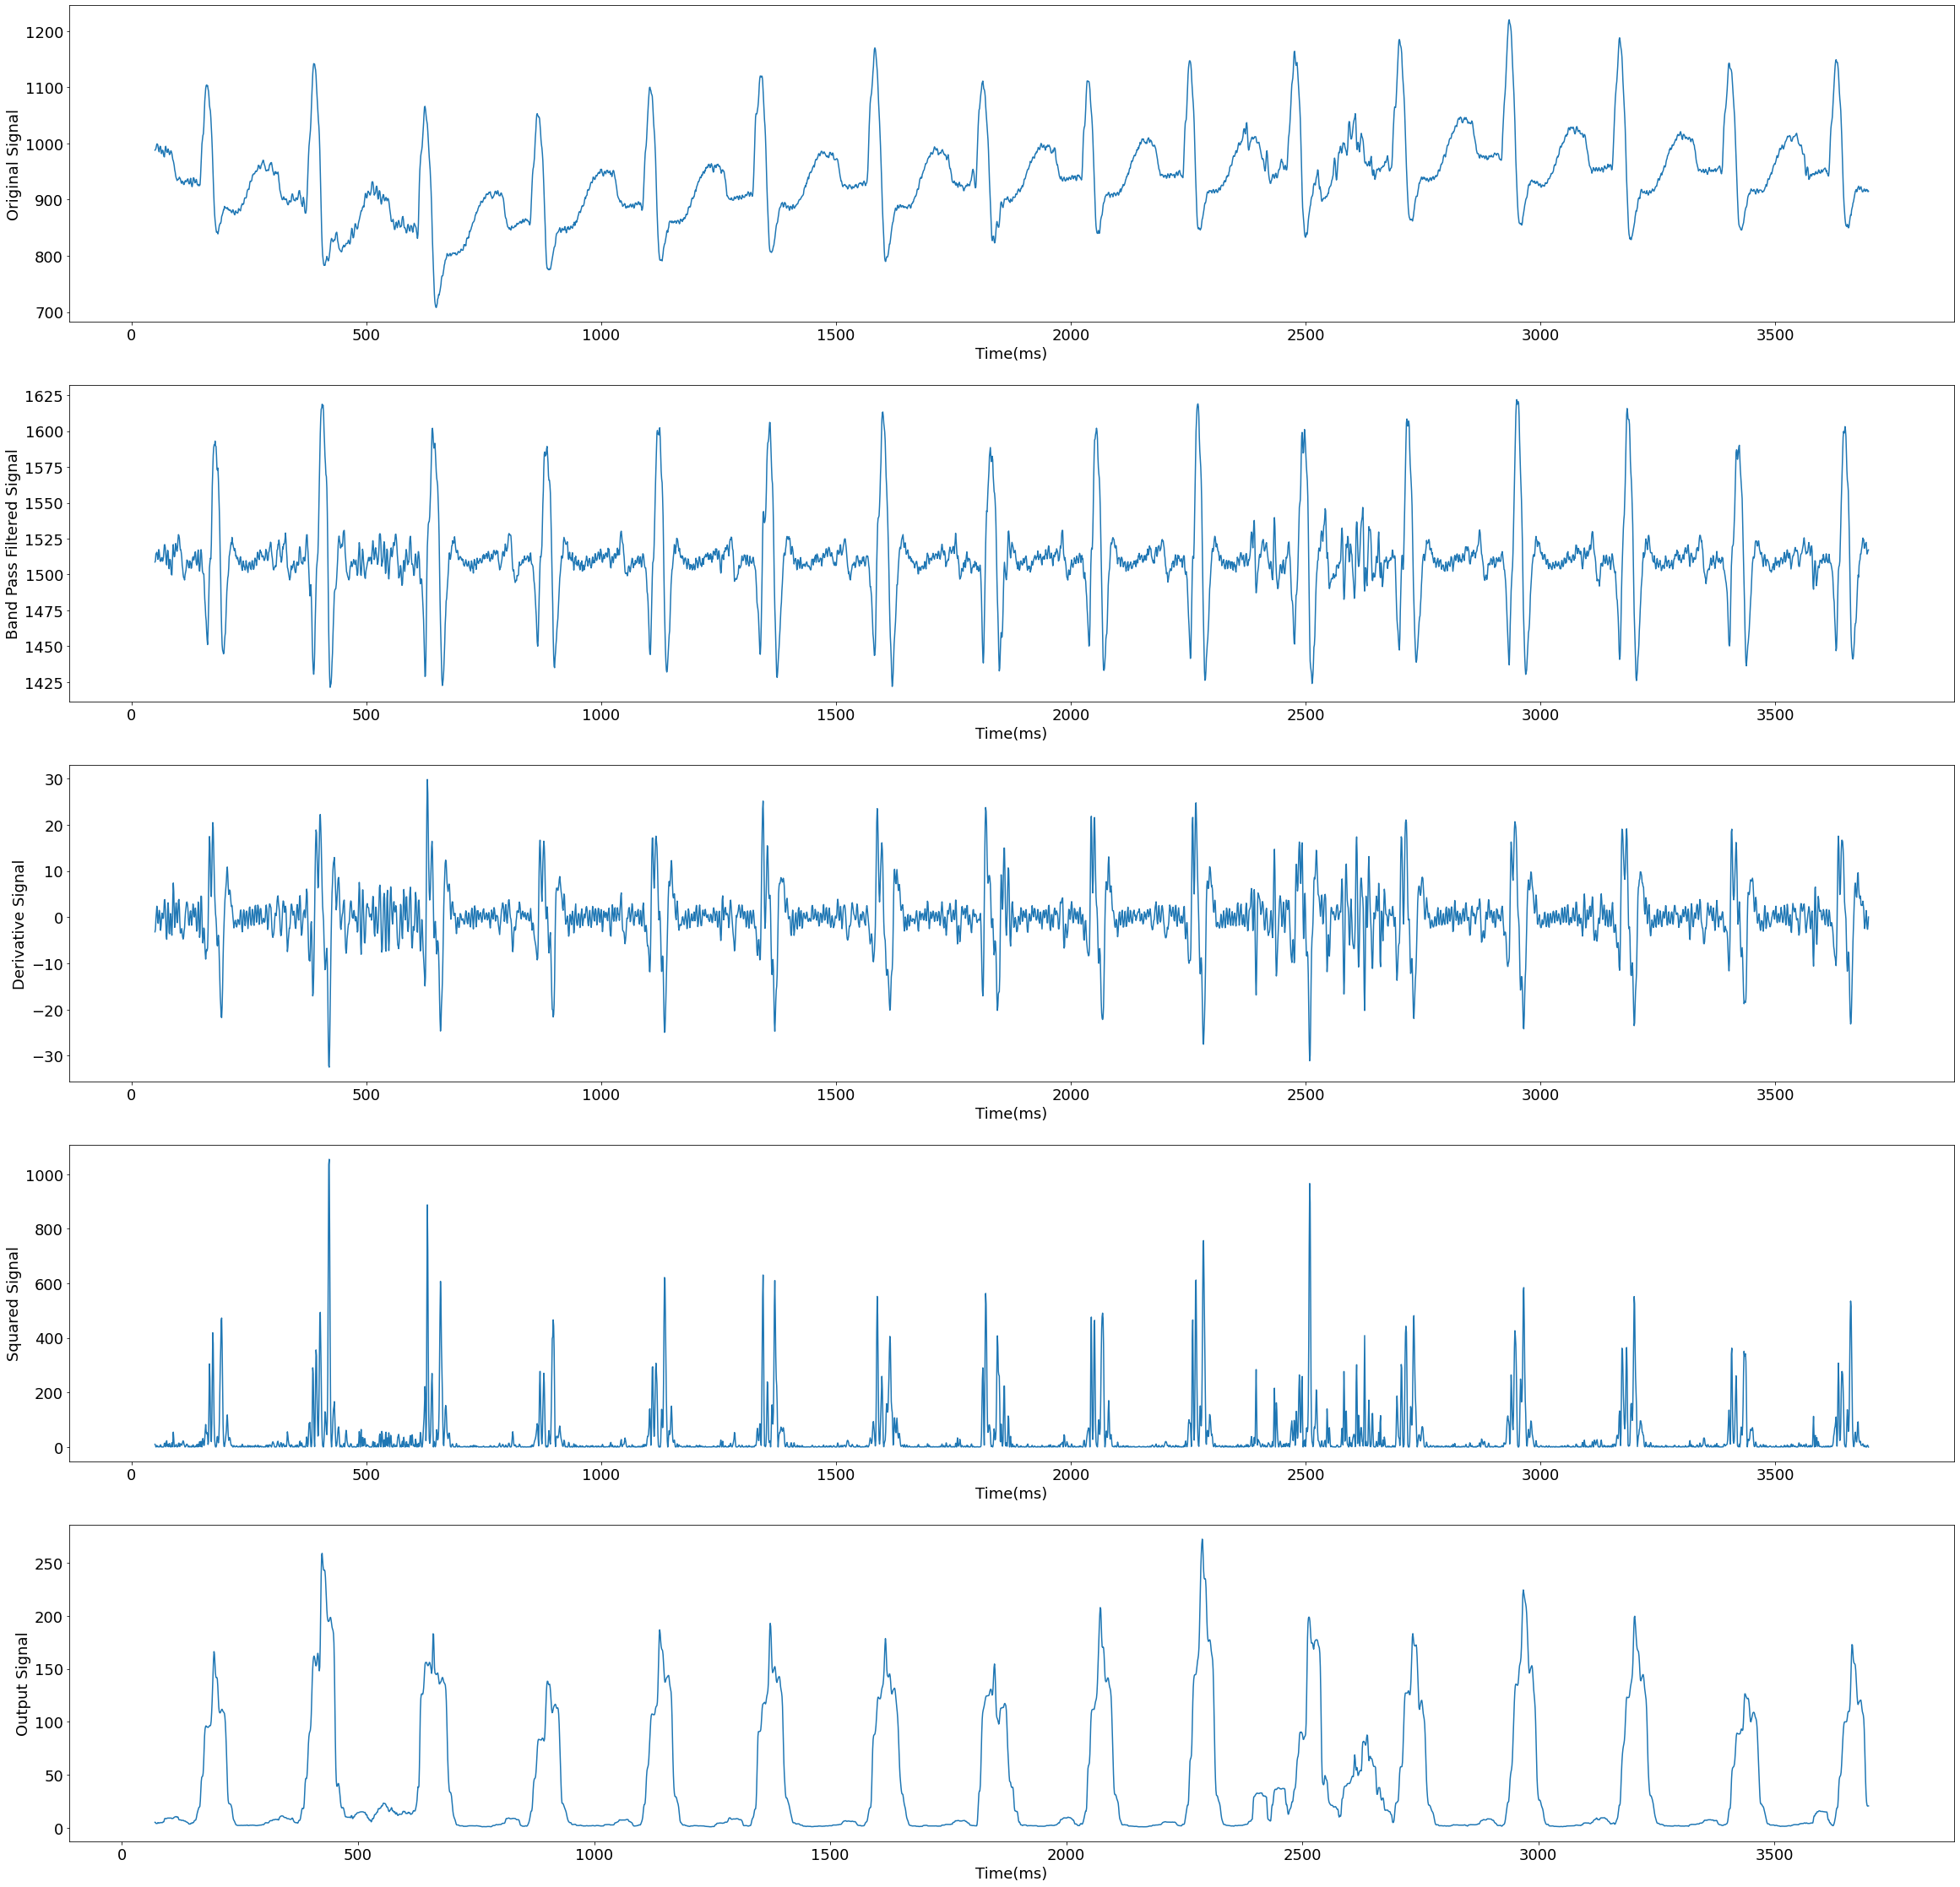

## Conclusion


The Pan-Tompkins algorithm is able to reduce the noise and give us the QRS complexes in the signal. It is very useful in estimating the heart rate from the signal. The signals which we were given is showing heart beats around 100 beats per minute. We can conclude whether the patient's health is normal or not by using this algorithm to generate the heart beats. The filters that are there in this algorithm are important in denoising the signal as well as generating the Q wave, R wave and S wave. The algorithm uses double thresholding technique and hence the sensitivity in detecting the peaks in the signal increases. The algorithm is adaptive and it automatically adapts the threshold and the RR interval limit. But the algorithm fails to detect the beats for the MIT/BIH arrythmia database.  


[TODO]